## FINAL PROJECT - Natural Language Processing - Neil Patrick Discaya (C0856896)

# About the Dataset
The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study

(1) sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects,
(2) the transferability of models among domains, i.e. conditions, and
(3) the transferability of models among different data sources (see 'Drug Review Dataset (Druglib.com)').

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

Attribute Information:

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful

Source:

Surya Kallumadi
Kansas State University
Manhattan, Kansas, USA
surya '@' ksu.edu

Felix Gräßer
Institut für Biomedizinische Technik
Technische Universität Dresden
Dresden, Germany
felix.graesser '@' tu-dresden.de

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import warnings; warnings.simplefilter('ignore')
import nltk
import re
from nltk.stem import SnowballStemmer

from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

I merge the train and test datasets to do the processing and exploratory data analysis for the whole dataset and split it again using train_test_split.

In [2]:
df_train = pd.read_csv(r"drugsComTrain_raw.tsv", sep=None, engine='python')
df_test = pd.read_csv(r"drugsComTest_raw.tsv", sep=None, engine='python')
df = pd.concat([df_train, df_test]) #combining the two file

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [4]:
df.describe()

,Unnamed: 0,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [5]:
#Null values
df.isnull().sum(axis = 0)

Unnamed: 0        0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [6]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [7]:
# delete/exclude unnecessary columns in the dataset
del df['Unnamed: 0']
del df['date']

In [8]:
# grouping data according to their condition and list out the first 30 popular use drugs
drug_per_condition = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drug_per_condition[:30]

condition
Not Listed / Othe                             253
Pain                                          219
Birth Control                                 181
High Blood Pressure                           146
Acne                                          127
Depression                                    115
Rheumatoid Arthritis                          107
Diabetes, Type 2                               97
Allergic Rhinitis                              95
Insomnia                                       85
Osteoarthritis                                 84
Bipolar Disorde                                82
Anxiety                                        81
Abnormal Uterine Bleeding                      77
Endometriosis                                  64
3</span> users found this comment helpful.     62
Psoriasis                                      61
Migraine                                       60
ADHD                                           58
4</span> users found this comment helpfu

Notice that there are conditions which are invalid. Replacing invalid data with 'NaN' such as 'Not Listed / Othe','3</span> users found this comment helpful.' and '3</span> users found this comment helpful.' and  in column 'condition' so that it will be processed and will be replaced by the correct condition together with the other Null values using the created dictionary.

In [9]:
# to replace invalid data in condition column with NaN
df.loc[df['condition'].str.contains('</span>',case=False, na=False), 'condition'] = 'NAN'
df['condition'].replace('NAN', np.NaN, inplace=True)
df['condition'].replace('Not Listed / Othe', np.NaN, inplace=True)

# creating dictionary and replacing missing values with the correct condition.
dictionary=df.set_index('drugName')['condition'].to_dict()
df.condition.fillna(df.drugName.map(dictionary), inplace=True)

In [10]:
drug_per_condition = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drug_per_condition[:30]

condition
Pain                         219
Birth Control                181
High Blood Pressure          146
Acne                         127
Depression                   115
Rheumatoid Arthritis         107
Diabetes, Type 2              97
Allergic Rhinitis             95
Insomnia                      85
Osteoarthritis                84
Bipolar Disorde               82
Anxiety                       81
Abnormal Uterine Bleeding     77
Endometriosis                 64
Psoriasis                     61
Migraine                      60
ADHD                          58
Asthma, Maintenance           56
Chronic Pain                  53
Urinary Tract Infection       53
Irritable Bowel Syndrome      52
Major Depressive Disorde      52
Migraine Prevention           51
Bronchitis                    47
Postmenopausal Symptoms       47
HIV Infection                 46
ibromyalgia                   46
Bacterial Infection           46
Dermatitis                    45
GERD                          45


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215063 non-null  object 
 1   condition    214983 non-null  object 
 2   review       215063 non-null  object 
 3   rating       215063 non-null  float64
 4   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 9.8+ MB


Notice that there are no longer conditions with invalid data and we also got rid of Missing or NaN Values.

In [12]:
df.head()

,drugName,condition,review,rating,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37


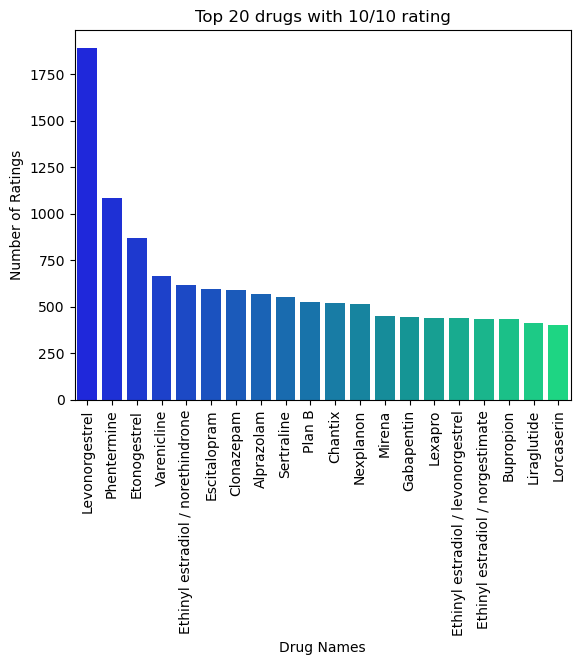

In [13]:
rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())
sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20],palette = 'winter')
sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

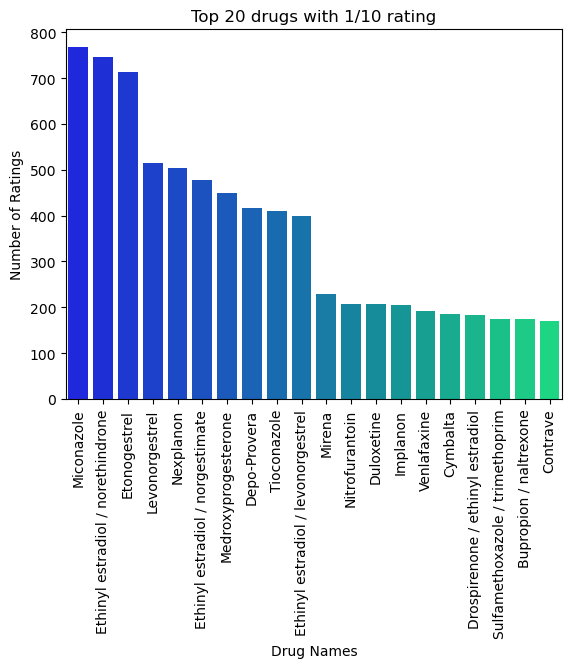

In [14]:
rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())
sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')
sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

#### Plotting the distribution of ratings

Text(0.5, 0, 'Rating')

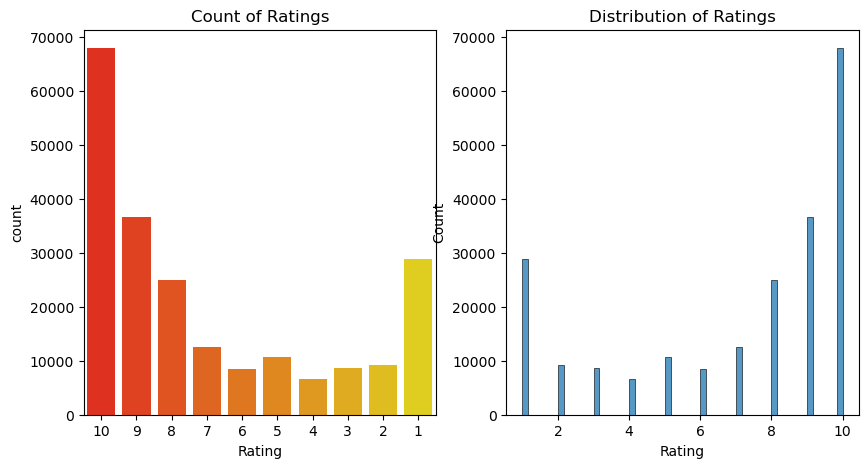

In [15]:
plt.rcParams['figure.figsize'] = [10,5]
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(x = df['rating'], palette = 'autumn', order = list(range(10, 0, -1)), ax = ax[0])
sns_2 = sns.histplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")
     

#### Word cloud of the reviews with rating equal to 10

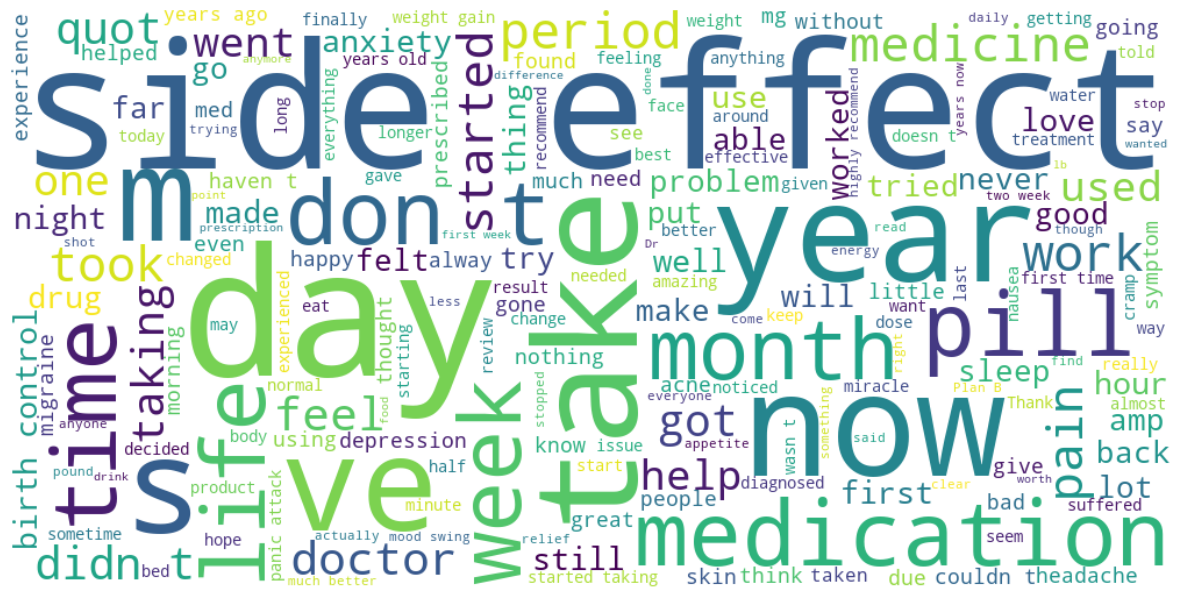

In [16]:
# Word cloud of the reviews with rating equal to 10
df_rate_ten = df.loc[df.rating == 10, 'review']
k = (' '.join(df_rate_ten))
wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

#### Word cloud of the reviews with rating equal to 1

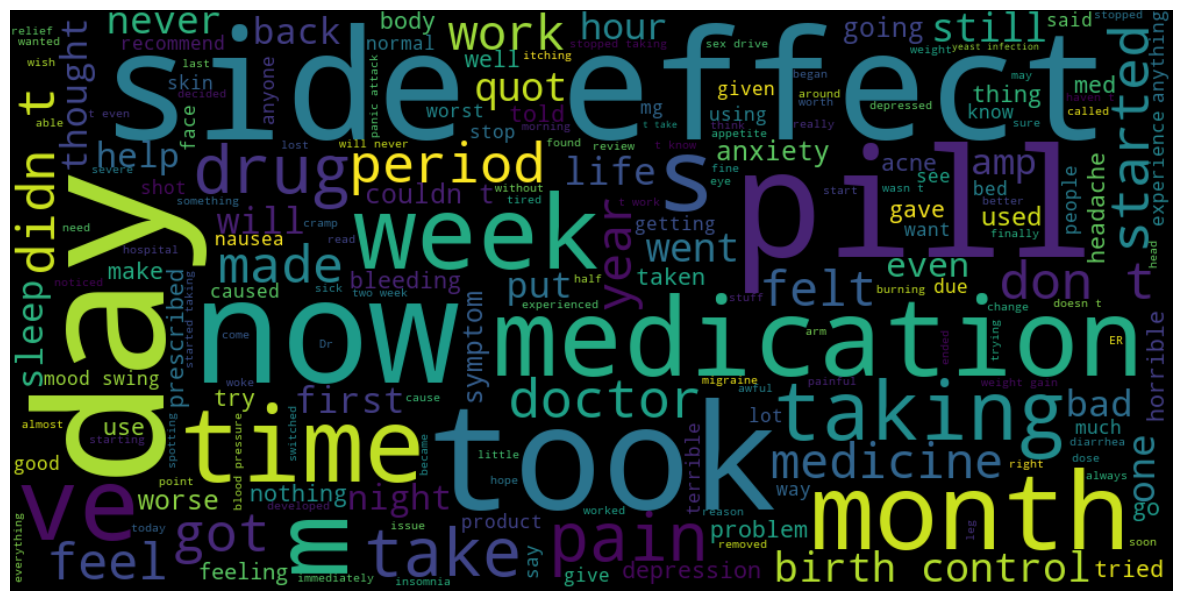

In [17]:
df_rate_one = df.loc[df.rating == 1, 'review']
k1 = (' '.join(df_rate_one))

wordcloud = WordCloud(width = 1000, height = 500).generate(k1)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

#### Plotting the distribution of common conditions

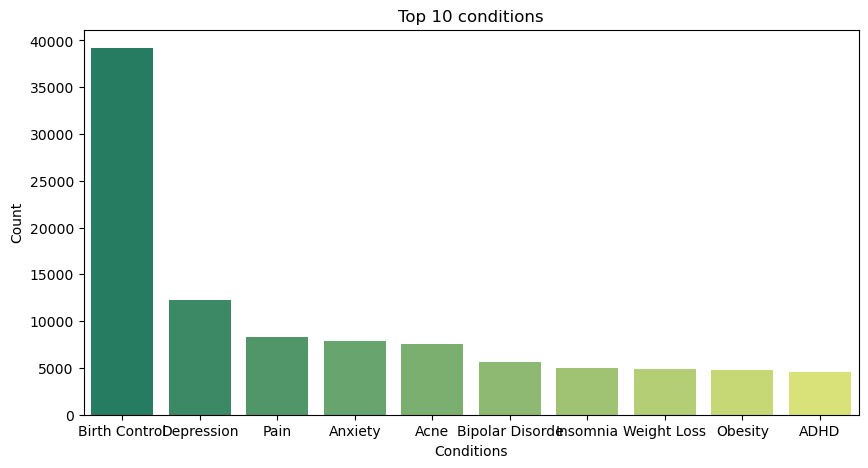

In [18]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns_ = sns.barplot(x = top_condition, y = values, palette = 'summer')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

Top 10 drugs which are used for the top condition, which is Birth Control

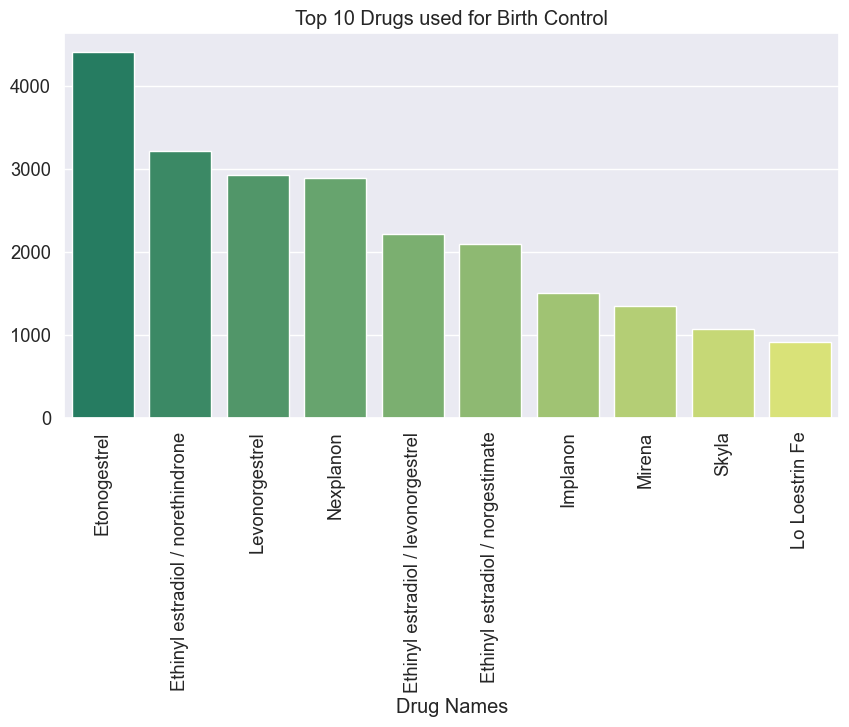

In [19]:
bc = df[df['condition'] == 'Birth Control']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = bc.index, y = bc.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

<AxesSubplot:xlabel='usefulCount', ylabel='Density'>

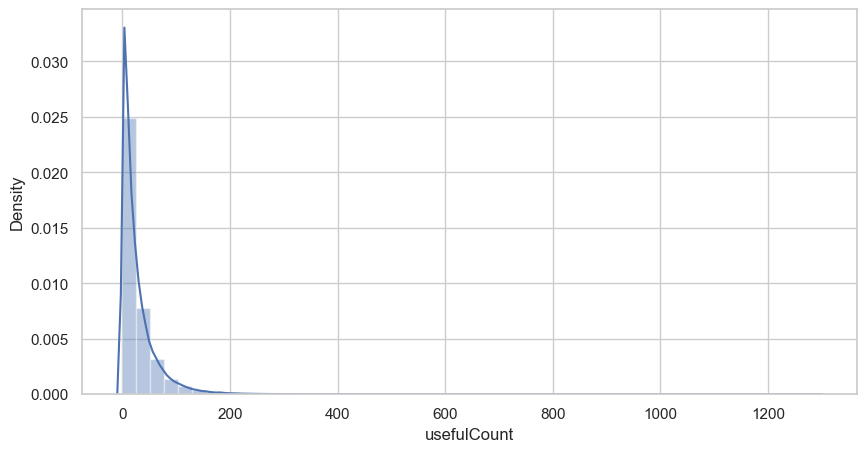

In [20]:
sns.set(style = 'whitegrid')
plt.rcParams['figure.figsize'] = [10, 5]
sns.distplot(df['usefulCount'].dropna())

<AxesSubplot:xlabel='rating', ylabel='usefulCount'>

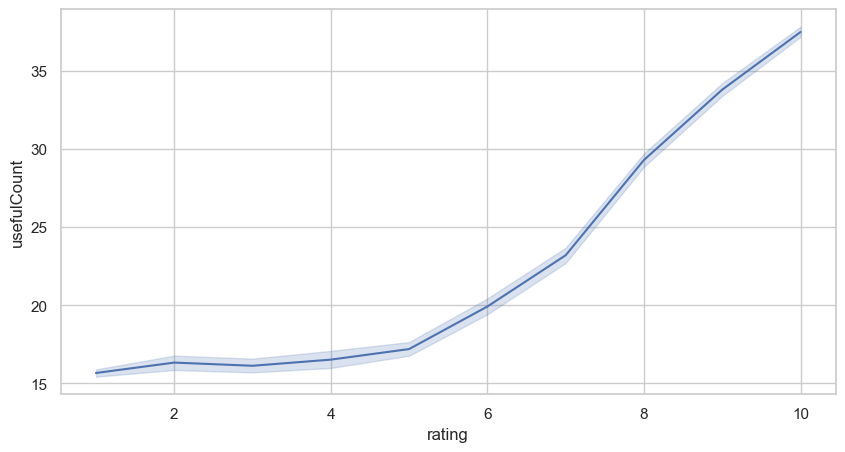

In [21]:
df.reset_index(level=0, inplace=True)
sns.lineplot(x=df['rating'],y=df['usefulCount'])

As the rating goes up the usefulcount goes up

In [22]:
df.head()

,index,drugName,condition,review,rating,usefulCount
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37


### Data Cleaning

In [23]:
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [24]:
# removing some stopwords from the list of stopwords as they are important for the analysis

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)
add_stop = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound', 'lb', 'month', 'day','night']
for j in add_stop:
    stops.add(j)

In [25]:
stemmer = SnowballStemmer('english')

def reviews_to_words(raw_review):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stops]
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    return( ' '.join(stemming_words))
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
# create a list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
punctuations = string.punctuation
# Creating tokenizer function
def tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    # Removing stop words
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations ]
    return tokens

In [26]:
df['review_clean'] = df['review'].apply(reviews_to_words)
df.head()

,index,drugName,condition,review,rating,usefulCount,review_clean
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27,no side effect take combin bystol fish oil
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192,son halfway fourth intuniv becam concern began...
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17,use take anoth contracept pill cycl happi ligh...
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10,first time use form birth control glad went pa...
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37,suboxon complet turn life around feel healthie...


### Sentiment Labeling based on rating and verifying it using Machine Learning Models 
Considering the following for Sentiment labeling of the reviews.
0 for negative (rating <= 5)
1 for positive (rating > 5)

In [27]:
df['review_sentiment'] = df['rating'].apply(lambda x: 1 if x > 5 else 0)

df['review_sentiment'].value_counts()

1    150768
0     64295
Name: review_sentiment, dtype: int64

In [28]:
df.head()

,index,drugName,condition,review,rating,usefulCount,review_clean,review_sentiment
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27,no side effect take combin bystol fish oil,1
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192,son halfway fourth intuniv becam concern began...,1
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17,use take anoth contracept pill cycl happi ligh...,0
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10,first time use form birth control glad went pa...,1
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37,suboxon complet turn life around feel healthie...,1


In [29]:
#Verification using Machine Learning Models 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review_clean'],df['review_sentiment'], test_size = 0.25, random_state = 0)
# Vectorizer and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.7)

X_train_tf = tfidf.fit_transform(X_train)
X_test_tf  = tfidf.transform(X_test)

In [30]:
lgbm = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model_lgbm = lgbm.fit(X_train_tf, y_train)

# Predictions
predictions = model_lgbm.predict(X_test_tf)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions), '\n')

print (classification_report(y_test, predictions))

The Accuracy of the model is :  0.9235576386564 

The confusion Matrix is 

[[13477  2642]
 [ 1468 36179]] 

              precision    recall  f1-score   support

           0       0.90      0.84      0.87     16119
           1       0.93      0.96      0.95     37647

    accuracy                           0.92     53766
   macro avg       0.92      0.90      0.91     53766
weighted avg       0.92      0.92      0.92     53766



In [31]:
cat = CatBoostClassifier(iterations = 10000,
                            learning_rate = 0.5);

model_cat = cat.fit(X_train_tf, y_train);
predictions2 = model_cat.predict(X_test_tf)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions2), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions2), '\n')

print (classification_report(y_test, predictions2))

0:	learn: 0.6012213	total: 310ms	remaining: 51m 35s
1:	learn: 0.5655592	total: 459ms	remaining: 38m 15s
2:	learn: 0.5470551	total: 610ms	remaining: 33m 51s
3:	learn: 0.5344543	total: 749ms	remaining: 31m 10s
4:	learn: 0.5244149	total: 895ms	remaining: 29m 48s
5:	learn: 0.5167428	total: 1.04s	remaining: 28m 46s
6:	learn: 0.5100994	total: 1.2s	remaining: 28m 36s
7:	learn: 0.5037291	total: 1.34s	remaining: 27m 55s
8:	learn: 0.4985745	total: 1.5s	remaining: 27m 42s
9:	learn: 0.4944247	total: 1.64s	remaining: 27m 15s
10:	learn: 0.4904627	total: 1.78s	remaining: 26m 55s
11:	learn: 0.4859172	total: 1.93s	remaining: 26m 44s
12:	learn: 0.4826105	total: 2.07s	remaining: 26m 30s
13:	learn: 0.4789870	total: 2.21s	remaining: 26m 17s
14:	learn: 0.4755128	total: 2.36s	remaining: 26m 8s
15:	learn: 0.4726821	total: 2.5s	remaining: 25m 59s
16:	learn: 0.4699150	total: 2.64s	remaining: 25m 49s
17:	learn: 0.4671736	total: 2.78s	remaining: 25m 42s
18:	learn: 0.4646428	total: 2.94s	remaining: 25m 43s
19:	lea

156:	learn: 0.3589092	total: 22s	remaining: 23m 1s
157:	learn: 0.3585668	total: 22.2s	remaining: 23m 1s
158:	learn: 0.3580571	total: 22.3s	remaining: 23m
159:	learn: 0.3576422	total: 22.5s	remaining: 23m 2s
160:	learn: 0.3572706	total: 22.6s	remaining: 23m 2s
161:	learn: 0.3568744	total: 22.8s	remaining: 23m 2s
162:	learn: 0.3564739	total: 22.9s	remaining: 23m 2s
163:	learn: 0.3562186	total: 23s	remaining: 23m 1s
164:	learn: 0.3558358	total: 23.2s	remaining: 23m
165:	learn: 0.3554200	total: 23.3s	remaining: 22m 59s
166:	learn: 0.3549436	total: 23.4s	remaining: 22m 59s
167:	learn: 0.3545740	total: 23.6s	remaining: 22m 58s
168:	learn: 0.3542362	total: 23.7s	remaining: 22m 58s
169:	learn: 0.3538742	total: 23.8s	remaining: 22m 58s
170:	learn: 0.3535082	total: 24s	remaining: 22m 57s
171:	learn: 0.3531098	total: 24.1s	remaining: 22m 57s
172:	learn: 0.3528521	total: 24.2s	remaining: 22m 56s
173:	learn: 0.3525551	total: 24.4s	remaining: 22m 56s
174:	learn: 0.3522812	total: 24.5s	remaining: 22m

310:	learn: 0.3100633	total: 43s	remaining: 22m 18s
311:	learn: 0.3097904	total: 43.1s	remaining: 22m 17s
312:	learn: 0.3095213	total: 43.2s	remaining: 22m 17s
313:	learn: 0.3092618	total: 43.3s	remaining: 22m 17s
314:	learn: 0.3090412	total: 43.5s	remaining: 22m 17s
315:	learn: 0.3087999	total: 43.6s	remaining: 22m 16s
316:	learn: 0.3084699	total: 43.8s	remaining: 22m 16s
317:	learn: 0.3082500	total: 43.9s	remaining: 22m 16s
318:	learn: 0.3079482	total: 44s	remaining: 22m 16s
319:	learn: 0.3075592	total: 44.2s	remaining: 22m 16s
320:	learn: 0.3072764	total: 44.3s	remaining: 22m 16s
321:	learn: 0.3070083	total: 44.5s	remaining: 22m 16s
322:	learn: 0.3067586	total: 44.6s	remaining: 22m 16s
323:	learn: 0.3063825	total: 44.7s	remaining: 22m 16s
324:	learn: 0.3061295	total: 44.9s	remaining: 22m 15s
325:	learn: 0.3058912	total: 45s	remaining: 22m 15s
326:	learn: 0.3056210	total: 45.1s	remaining: 22m 15s
327:	learn: 0.3053692	total: 45.3s	remaining: 22m 14s
328:	learn: 0.3051077	total: 45.4s

466:	learn: 0.2715071	total: 1m 4s	remaining: 21m 53s
467:	learn: 0.2711943	total: 1m 4s	remaining: 21m 52s
468:	learn: 0.2709980	total: 1m 4s	remaining: 21m 52s
469:	learn: 0.2708349	total: 1m 4s	remaining: 21m 52s
470:	learn: 0.2706619	total: 1m 4s	remaining: 21m 52s
471:	learn: 0.2703292	total: 1m 4s	remaining: 21m 52s
472:	learn: 0.2700197	total: 1m 5s	remaining: 21m 51s
473:	learn: 0.2698263	total: 1m 5s	remaining: 21m 51s
474:	learn: 0.2695957	total: 1m 5s	remaining: 21m 51s
475:	learn: 0.2693607	total: 1m 5s	remaining: 21m 51s
476:	learn: 0.2691597	total: 1m 5s	remaining: 21m 51s
477:	learn: 0.2689275	total: 1m 5s	remaining: 21m 50s
478:	learn: 0.2687002	total: 1m 5s	remaining: 21m 50s
479:	learn: 0.2684316	total: 1m 6s	remaining: 21m 50s
480:	learn: 0.2681766	total: 1m 6s	remaining: 21m 50s
481:	learn: 0.2680257	total: 1m 6s	remaining: 21m 50s
482:	learn: 0.2677844	total: 1m 6s	remaining: 21m 50s
483:	learn: 0.2676151	total: 1m 6s	remaining: 21m 49s
484:	learn: 0.2673573	total:

616:	learn: 0.2415768	total: 1m 24s	remaining: 21m 23s
617:	learn: 0.2413478	total: 1m 24s	remaining: 21m 23s
618:	learn: 0.2411415	total: 1m 24s	remaining: 21m 22s
619:	learn: 0.2410155	total: 1m 24s	remaining: 21m 22s
620:	learn: 0.2408262	total: 1m 24s	remaining: 21m 22s
621:	learn: 0.2406519	total: 1m 25s	remaining: 21m 22s
622:	learn: 0.2404112	total: 1m 25s	remaining: 21m 22s
623:	learn: 0.2402337	total: 1m 25s	remaining: 21m 22s
624:	learn: 0.2400726	total: 1m 25s	remaining: 21m 21s
625:	learn: 0.2398663	total: 1m 25s	remaining: 21m 21s
626:	learn: 0.2396873	total: 1m 25s	remaining: 21m 21s
627:	learn: 0.2395079	total: 1m 25s	remaining: 21m 21s
628:	learn: 0.2393350	total: 1m 26s	remaining: 21m 21s
629:	learn: 0.2391770	total: 1m 26s	remaining: 21m 21s
630:	learn: 0.2390283	total: 1m 26s	remaining: 21m 20s
631:	learn: 0.2387917	total: 1m 26s	remaining: 21m 20s
632:	learn: 0.2386458	total: 1m 26s	remaining: 21m 20s
633:	learn: 0.2384731	total: 1m 26s	remaining: 21m 20s
634:	learn

768:	learn: 0.2154904	total: 1m 44s	remaining: 20m 55s
769:	learn: 0.2152955	total: 1m 44s	remaining: 20m 55s
770:	learn: 0.2151284	total: 1m 44s	remaining: 20m 55s
771:	learn: 0.2149985	total: 1m 45s	remaining: 20m 55s
772:	learn: 0.2147910	total: 1m 45s	remaining: 20m 55s
773:	learn: 0.2146382	total: 1m 45s	remaining: 20m 54s
774:	learn: 0.2144886	total: 1m 45s	remaining: 20m 54s
775:	learn: 0.2143178	total: 1m 45s	remaining: 20m 54s
776:	learn: 0.2142058	total: 1m 45s	remaining: 20m 54s
777:	learn: 0.2140459	total: 1m 45s	remaining: 20m 54s
778:	learn: 0.2138537	total: 1m 45s	remaining: 20m 54s
779:	learn: 0.2137334	total: 1m 46s	remaining: 20m 54s
780:	learn: 0.2136183	total: 1m 46s	remaining: 20m 53s
781:	learn: 0.2134494	total: 1m 46s	remaining: 20m 53s
782:	learn: 0.2133379	total: 1m 46s	remaining: 20m 53s
783:	learn: 0.2131739	total: 1m 46s	remaining: 20m 53s
784:	learn: 0.2129368	total: 1m 46s	remaining: 20m 53s
785:	learn: 0.2128428	total: 1m 46s	remaining: 20m 52s
786:	learn

918:	learn: 0.1942627	total: 2m 4s	remaining: 20m 34s
919:	learn: 0.1941352	total: 2m 5s	remaining: 20m 34s
920:	learn: 0.1940229	total: 2m 5s	remaining: 20m 34s
921:	learn: 0.1939291	total: 2m 5s	remaining: 20m 33s
922:	learn: 0.1938608	total: 2m 5s	remaining: 20m 33s
923:	learn: 0.1937677	total: 2m 5s	remaining: 20m 33s
924:	learn: 0.1936429	total: 2m 5s	remaining: 20m 33s
925:	learn: 0.1935007	total: 2m 5s	remaining: 20m 33s
926:	learn: 0.1934121	total: 2m 5s	remaining: 20m 33s
927:	learn: 0.1932709	total: 2m 6s	remaining: 20m 33s
928:	learn: 0.1931794	total: 2m 6s	remaining: 20m 32s
929:	learn: 0.1929229	total: 2m 6s	remaining: 20m 32s
930:	learn: 0.1928563	total: 2m 6s	remaining: 20m 32s
931:	learn: 0.1927492	total: 2m 6s	remaining: 20m 32s
932:	learn: 0.1926333	total: 2m 6s	remaining: 20m 32s
933:	learn: 0.1924936	total: 2m 6s	remaining: 20m 31s
934:	learn: 0.1923134	total: 2m 7s	remaining: 20m 31s
935:	learn: 0.1922039	total: 2m 7s	remaining: 20m 31s
936:	learn: 0.1920412	total:

1068:	learn: 0.1756453	total: 2m 24s	remaining: 20m 10s
1069:	learn: 0.1755179	total: 2m 25s	remaining: 20m 10s
1070:	learn: 0.1754188	total: 2m 25s	remaining: 20m 10s
1071:	learn: 0.1752900	total: 2m 25s	remaining: 20m 10s
1072:	learn: 0.1751425	total: 2m 25s	remaining: 20m 10s
1073:	learn: 0.1750446	total: 2m 25s	remaining: 20m 9s
1074:	learn: 0.1748838	total: 2m 25s	remaining: 20m 9s
1075:	learn: 0.1747014	total: 2m 25s	remaining: 20m 9s
1076:	learn: 0.1745867	total: 2m 26s	remaining: 20m 9s
1077:	learn: 0.1744091	total: 2m 26s	remaining: 20m 9s
1078:	learn: 0.1742935	total: 2m 26s	remaining: 20m 9s
1079:	learn: 0.1741660	total: 2m 26s	remaining: 20m 9s
1080:	learn: 0.1739930	total: 2m 26s	remaining: 20m 9s
1081:	learn: 0.1739109	total: 2m 26s	remaining: 20m 8s
1082:	learn: 0.1737762	total: 2m 26s	remaining: 20m 8s
1083:	learn: 0.1736486	total: 2m 26s	remaining: 20m 8s
1084:	learn: 0.1735391	total: 2m 27s	remaining: 20m 8s
1085:	learn: 0.1734546	total: 2m 27s	remaining: 20m 8s
1086:

1216:	learn: 0.1593950	total: 2m 44s	remaining: 19m 48s
1217:	learn: 0.1592685	total: 2m 44s	remaining: 19m 48s
1218:	learn: 0.1591738	total: 2m 44s	remaining: 19m 48s
1219:	learn: 0.1590519	total: 2m 45s	remaining: 19m 48s
1220:	learn: 0.1589455	total: 2m 45s	remaining: 19m 47s
1221:	learn: 0.1588052	total: 2m 45s	remaining: 19m 47s
1222:	learn: 0.1586969	total: 2m 45s	remaining: 19m 47s
1223:	learn: 0.1585710	total: 2m 45s	remaining: 19m 47s
1224:	learn: 0.1585078	total: 2m 45s	remaining: 19m 47s
1225:	learn: 0.1583959	total: 2m 45s	remaining: 19m 47s
1226:	learn: 0.1582994	total: 2m 46s	remaining: 19m 47s
1227:	learn: 0.1581612	total: 2m 46s	remaining: 19m 47s
1228:	learn: 0.1580776	total: 2m 46s	remaining: 19m 46s
1229:	learn: 0.1579804	total: 2m 46s	remaining: 19m 46s
1230:	learn: 0.1578648	total: 2m 46s	remaining: 19m 46s
1231:	learn: 0.1577401	total: 2m 46s	remaining: 19m 46s
1232:	learn: 0.1575904	total: 2m 46s	remaining: 19m 46s
1233:	learn: 0.1575272	total: 2m 46s	remaining: 

1364:	learn: 0.1454777	total: 3m 4s	remaining: 19m 27s
1365:	learn: 0.1453179	total: 3m 4s	remaining: 19m 27s
1366:	learn: 0.1452086	total: 3m 4s	remaining: 19m 27s
1367:	learn: 0.1450975	total: 3m 4s	remaining: 19m 27s
1368:	learn: 0.1450216	total: 3m 5s	remaining: 19m 27s
1369:	learn: 0.1449621	total: 3m 5s	remaining: 19m 26s
1370:	learn: 0.1448618	total: 3m 5s	remaining: 19m 26s
1371:	learn: 0.1447876	total: 3m 5s	remaining: 19m 26s
1372:	learn: 0.1447464	total: 3m 5s	remaining: 19m 26s
1373:	learn: 0.1446455	total: 3m 5s	remaining: 19m 26s
1374:	learn: 0.1445947	total: 3m 5s	remaining: 19m 26s
1375:	learn: 0.1445437	total: 3m 6s	remaining: 19m 26s
1376:	learn: 0.1444866	total: 3m 6s	remaining: 19m 26s
1377:	learn: 0.1443865	total: 3m 6s	remaining: 19m 25s
1378:	learn: 0.1443005	total: 3m 6s	remaining: 19m 25s
1379:	learn: 0.1442184	total: 3m 6s	remaining: 19m 25s
1380:	learn: 0.1441539	total: 3m 6s	remaining: 19m 25s
1381:	learn: 0.1441104	total: 3m 6s	remaining: 19m 25s
1382:	lear

1512:	learn: 0.1334692	total: 3m 24s	remaining: 19m 8s
1513:	learn: 0.1333758	total: 3m 24s	remaining: 19m 8s
1514:	learn: 0.1332493	total: 3m 25s	remaining: 19m 8s
1515:	learn: 0.1331370	total: 3m 25s	remaining: 19m 8s
1516:	learn: 0.1330729	total: 3m 25s	remaining: 19m 7s
1517:	learn: 0.1330376	total: 3m 25s	remaining: 19m 7s
1518:	learn: 0.1329785	total: 3m 25s	remaining: 19m 7s
1519:	learn: 0.1329498	total: 3m 25s	remaining: 19m 7s
1520:	learn: 0.1328759	total: 3m 25s	remaining: 19m 7s
1521:	learn: 0.1327594	total: 3m 25s	remaining: 19m 7s
1522:	learn: 0.1327011	total: 3m 26s	remaining: 19m 6s
1523:	learn: 0.1326144	total: 3m 26s	remaining: 19m 6s
1524:	learn: 0.1325657	total: 3m 26s	remaining: 19m 6s
1525:	learn: 0.1325130	total: 3m 26s	remaining: 19m 6s
1526:	learn: 0.1324733	total: 3m 26s	remaining: 19m 6s
1527:	learn: 0.1324010	total: 3m 26s	remaining: 19m 6s
1528:	learn: 0.1323015	total: 3m 26s	remaining: 19m 5s
1529:	learn: 0.1322152	total: 3m 26s	remaining: 19m 5s
1530:	lear

1660:	learn: 0.1227543	total: 3m 44s	remaining: 18m 46s
1661:	learn: 0.1227044	total: 3m 44s	remaining: 18m 46s
1662:	learn: 0.1226666	total: 3m 44s	remaining: 18m 45s
1663:	learn: 0.1225777	total: 3m 44s	remaining: 18m 45s
1664:	learn: 0.1225167	total: 3m 44s	remaining: 18m 45s
1665:	learn: 0.1224515	total: 3m 44s	remaining: 18m 45s
1666:	learn: 0.1223926	total: 3m 45s	remaining: 18m 45s
1667:	learn: 0.1223661	total: 3m 45s	remaining: 18m 44s
1668:	learn: 0.1223075	total: 3m 45s	remaining: 18m 44s
1669:	learn: 0.1222426	total: 3m 45s	remaining: 18m 44s
1670:	learn: 0.1221805	total: 3m 45s	remaining: 18m 44s
1671:	learn: 0.1221092	total: 3m 45s	remaining: 18m 44s
1672:	learn: 0.1219613	total: 3m 45s	remaining: 18m 44s
1673:	learn: 0.1219230	total: 3m 46s	remaining: 18m 44s
1674:	learn: 0.1218281	total: 3m 46s	remaining: 18m 44s
1675:	learn: 0.1218064	total: 3m 46s	remaining: 18m 43s
1676:	learn: 0.1217539	total: 3m 46s	remaining: 18m 43s
1677:	learn: 0.1216368	total: 3m 46s	remaining: 

1808:	learn: 0.1129884	total: 4m 3s	remaining: 18m 24s
1809:	learn: 0.1129705	total: 4m 4s	remaining: 18m 24s
1810:	learn: 0.1129085	total: 4m 4s	remaining: 18m 24s
1811:	learn: 0.1128621	total: 4m 4s	remaining: 18m 23s
1812:	learn: 0.1127905	total: 4m 4s	remaining: 18m 23s
1813:	learn: 0.1127206	total: 4m 4s	remaining: 18m 23s
1814:	learn: 0.1125993	total: 4m 4s	remaining: 18m 23s
1815:	learn: 0.1125505	total: 4m 4s	remaining: 18m 23s
1816:	learn: 0.1124712	total: 4m 4s	remaining: 18m 23s
1817:	learn: 0.1124012	total: 4m 5s	remaining: 18m 23s
1818:	learn: 0.1123460	total: 4m 5s	remaining: 18m 22s
1819:	learn: 0.1122939	total: 4m 5s	remaining: 18m 22s
1820:	learn: 0.1122176	total: 4m 5s	remaining: 18m 22s
1821:	learn: 0.1121711	total: 4m 5s	remaining: 18m 22s
1822:	learn: 0.1121207	total: 4m 5s	remaining: 18m 22s
1823:	learn: 0.1120448	total: 4m 5s	remaining: 18m 22s
1824:	learn: 0.1119481	total: 4m 6s	remaining: 18m 22s
1825:	learn: 0.1118666	total: 4m 6s	remaining: 18m 21s
1826:	lear

1956:	learn: 0.1044487	total: 4m 23s	remaining: 18m 4s
1957:	learn: 0.1044102	total: 4m 24s	remaining: 18m 4s
1958:	learn: 0.1043483	total: 4m 24s	remaining: 18m 4s
1959:	learn: 0.1043212	total: 4m 24s	remaining: 18m 4s
1960:	learn: 0.1042829	total: 4m 24s	remaining: 18m 4s
1961:	learn: 0.1042506	total: 4m 24s	remaining: 18m 4s
1962:	learn: 0.1041851	total: 4m 24s	remaining: 18m 3s
1963:	learn: 0.1041470	total: 4m 24s	remaining: 18m 3s
1964:	learn: 0.1041188	total: 4m 25s	remaining: 18m 3s
1965:	learn: 0.1040812	total: 4m 25s	remaining: 18m 3s
1966:	learn: 0.1039986	total: 4m 25s	remaining: 18m 3s
1967:	learn: 0.1039793	total: 4m 25s	remaining: 18m 3s
1968:	learn: 0.1038839	total: 4m 25s	remaining: 18m 3s
1969:	learn: 0.1038043	total: 4m 25s	remaining: 18m 3s
1970:	learn: 0.1037469	total: 4m 25s	remaining: 18m 2s
1971:	learn: 0.1037127	total: 4m 25s	remaining: 18m 2s
1972:	learn: 0.1036437	total: 4m 26s	remaining: 18m 2s
1973:	learn: 0.1035896	total: 4m 26s	remaining: 18m 2s
1974:	lear

2104:	learn: 0.0969502	total: 4m 43s	remaining: 17m 43s
2105:	learn: 0.0968752	total: 4m 43s	remaining: 17m 43s
2106:	learn: 0.0968014	total: 4m 43s	remaining: 17m 43s
2107:	learn: 0.0967429	total: 4m 43s	remaining: 17m 42s
2108:	learn: 0.0966703	total: 4m 44s	remaining: 17m 42s
2109:	learn: 0.0966327	total: 4m 44s	remaining: 17m 42s
2110:	learn: 0.0965741	total: 4m 44s	remaining: 17m 42s
2111:	learn: 0.0965522	total: 4m 44s	remaining: 17m 42s
2112:	learn: 0.0964850	total: 4m 44s	remaining: 17m 42s
2113:	learn: 0.0964339	total: 4m 44s	remaining: 17m 42s
2114:	learn: 0.0964101	total: 4m 44s	remaining: 17m 41s
2115:	learn: 0.0963655	total: 4m 44s	remaining: 17m 41s
2116:	learn: 0.0963247	total: 4m 45s	remaining: 17m 41s
2117:	learn: 0.0963038	total: 4m 45s	remaining: 17m 41s
2118:	learn: 0.0962718	total: 4m 45s	remaining: 17m 41s
2119:	learn: 0.0962179	total: 4m 45s	remaining: 17m 41s
2120:	learn: 0.0961540	total: 4m 45s	remaining: 17m 41s
2121:	learn: 0.0960967	total: 4m 45s	remaining: 

2252:	learn: 0.0899713	total: 5m 3s	remaining: 17m 22s
2253:	learn: 0.0899078	total: 5m 3s	remaining: 17m 22s
2254:	learn: 0.0898957	total: 5m 3s	remaining: 17m 21s
2255:	learn: 0.0898634	total: 5m 3s	remaining: 17m 21s
2256:	learn: 0.0897916	total: 5m 3s	remaining: 17m 21s
2257:	learn: 0.0897613	total: 5m 3s	remaining: 17m 21s
2258:	learn: 0.0897303	total: 5m 3s	remaining: 17m 21s
2259:	learn: 0.0897058	total: 5m 4s	remaining: 17m 21s
2260:	learn: 0.0896610	total: 5m 4s	remaining: 17m 21s
2261:	learn: 0.0896150	total: 5m 4s	remaining: 17m 20s
2262:	learn: 0.0895463	total: 5m 4s	remaining: 17m 20s
2263:	learn: 0.0895011	total: 5m 4s	remaining: 17m 20s
2264:	learn: 0.0894441	total: 5m 4s	remaining: 17m 20s
2265:	learn: 0.0893813	total: 5m 4s	remaining: 17m 20s
2266:	learn: 0.0893396	total: 5m 4s	remaining: 17m 20s
2267:	learn: 0.0892983	total: 5m 5s	remaining: 17m 20s
2268:	learn: 0.0892457	total: 5m 5s	remaining: 17m 19s
2269:	learn: 0.0891965	total: 5m 5s	remaining: 17m 19s
2270:	lear

2402:	learn: 0.0835289	total: 5m 23s	remaining: 17m 2s
2403:	learn: 0.0835021	total: 5m 23s	remaining: 17m 2s
2404:	learn: 0.0834682	total: 5m 23s	remaining: 17m 2s
2405:	learn: 0.0834339	total: 5m 23s	remaining: 17m 1s
2406:	learn: 0.0834019	total: 5m 23s	remaining: 17m 1s
2407:	learn: 0.0833291	total: 5m 24s	remaining: 17m 1s
2408:	learn: 0.0833020	total: 5m 24s	remaining: 17m 1s
2409:	learn: 0.0832922	total: 5m 24s	remaining: 17m 1s
2410:	learn: 0.0832687	total: 5m 24s	remaining: 17m 1s
2411:	learn: 0.0831972	total: 5m 24s	remaining: 17m 1s
2412:	learn: 0.0831421	total: 5m 24s	remaining: 17m
2413:	learn: 0.0831132	total: 5m 24s	remaining: 17m
2414:	learn: 0.0830687	total: 5m 24s	remaining: 17m
2415:	learn: 0.0830161	total: 5m 25s	remaining: 17m
2416:	learn: 0.0829628	total: 5m 25s	remaining: 17m
2417:	learn: 0.0829386	total: 5m 25s	remaining: 17m
2418:	learn: 0.0829110	total: 5m 25s	remaining: 17m
2419:	learn: 0.0828731	total: 5m 25s	remaining: 17m
2420:	learn: 0.0828596	total: 5m 2

2550:	learn: 0.0777785	total: 5m 43s	remaining: 16m 41s
2551:	learn: 0.0777481	total: 5m 43s	remaining: 16m 41s
2552:	learn: 0.0777088	total: 5m 43s	remaining: 16m 41s
2553:	learn: 0.0776848	total: 5m 43s	remaining: 16m 41s
2554:	learn: 0.0776255	total: 5m 43s	remaining: 16m 41s
2555:	learn: 0.0775938	total: 5m 43s	remaining: 16m 41s
2556:	learn: 0.0775878	total: 5m 43s	remaining: 16m 40s
2557:	learn: 0.0775489	total: 5m 43s	remaining: 16m 40s
2558:	learn: 0.0775311	total: 5m 44s	remaining: 16m 40s
2559:	learn: 0.0775011	total: 5m 44s	remaining: 16m 40s
2560:	learn: 0.0774433	total: 5m 44s	remaining: 16m 40s
2561:	learn: 0.0774005	total: 5m 44s	remaining: 16m 40s
2562:	learn: 0.0773539	total: 5m 44s	remaining: 16m 40s
2563:	learn: 0.0773419	total: 5m 44s	remaining: 16m 39s
2564:	learn: 0.0773183	total: 5m 44s	remaining: 16m 39s
2565:	learn: 0.0772797	total: 5m 45s	remaining: 16m 39s
2566:	learn: 0.0772461	total: 5m 45s	remaining: 16m 39s
2567:	learn: 0.0772329	total: 5m 45s	remaining: 

2698:	learn: 0.0729110	total: 6m 2s	remaining: 16m 20s
2699:	learn: 0.0728774	total: 6m 2s	remaining: 16m 20s
2700:	learn: 0.0728302	total: 6m 2s	remaining: 16m 20s
2701:	learn: 0.0728121	total: 6m 2s	remaining: 16m 20s
2702:	learn: 0.0727681	total: 6m 3s	remaining: 16m 19s
2703:	learn: 0.0727336	total: 6m 3s	remaining: 16m 19s
2704:	learn: 0.0726996	total: 6m 3s	remaining: 16m 19s
2705:	learn: 0.0726493	total: 6m 3s	remaining: 16m 19s
2706:	learn: 0.0726213	total: 6m 3s	remaining: 16m 19s
2707:	learn: 0.0725759	total: 6m 3s	remaining: 16m 19s
2708:	learn: 0.0725539	total: 6m 3s	remaining: 16m 19s
2709:	learn: 0.0725269	total: 6m 3s	remaining: 16m 18s
2710:	learn: 0.0724787	total: 6m 4s	remaining: 16m 18s
2711:	learn: 0.0724498	total: 6m 4s	remaining: 16m 18s
2712:	learn: 0.0724042	total: 6m 4s	remaining: 16m 18s
2713:	learn: 0.0723445	total: 6m 4s	remaining: 16m 18s
2714:	learn: 0.0723005	total: 6m 4s	remaining: 16m 18s
2715:	learn: 0.0722608	total: 6m 4s	remaining: 16m 18s
2716:	lear

2848:	learn: 0.0681704	total: 6m 22s	remaining: 15m 59s
2849:	learn: 0.0681108	total: 6m 22s	remaining: 15m 59s
2850:	learn: 0.0680638	total: 6m 22s	remaining: 15m 59s
2851:	learn: 0.0680325	total: 6m 22s	remaining: 15m 59s
2852:	learn: 0.0679999	total: 6m 23s	remaining: 15m 59s
2853:	learn: 0.0679685	total: 6m 23s	remaining: 15m 59s
2854:	learn: 0.0679438	total: 6m 23s	remaining: 15m 59s
2855:	learn: 0.0679140	total: 6m 23s	remaining: 15m 59s
2856:	learn: 0.0678531	total: 6m 23s	remaining: 15m 59s
2857:	learn: 0.0678246	total: 6m 23s	remaining: 15m 59s
2858:	learn: 0.0678030	total: 6m 23s	remaining: 15m 58s
2859:	learn: 0.0677771	total: 6m 24s	remaining: 15m 58s
2860:	learn: 0.0677598	total: 6m 24s	remaining: 15m 58s
2861:	learn: 0.0677340	total: 6m 24s	remaining: 15m 58s
2862:	learn: 0.0677109	total: 6m 24s	remaining: 15m 58s
2863:	learn: 0.0676948	total: 6m 24s	remaining: 15m 58s
2864:	learn: 0.0676576	total: 6m 24s	remaining: 15m 58s
2865:	learn: 0.0676370	total: 6m 24s	remaining: 

2996:	learn: 0.0638038	total: 6m 42s	remaining: 15m 40s
2997:	learn: 0.0637672	total: 6m 42s	remaining: 15m 39s
2998:	learn: 0.0637534	total: 6m 42s	remaining: 15m 39s
2999:	learn: 0.0637431	total: 6m 42s	remaining: 15m 39s
3000:	learn: 0.0637159	total: 6m 42s	remaining: 15m 39s
3001:	learn: 0.0636945	total: 6m 42s	remaining: 15m 39s
3002:	learn: 0.0636543	total: 6m 43s	remaining: 15m 39s
3003:	learn: 0.0636129	total: 6m 43s	remaining: 15m 39s
3004:	learn: 0.0635626	total: 6m 43s	remaining: 15m 38s
3005:	learn: 0.0635350	total: 6m 43s	remaining: 15m 38s
3006:	learn: 0.0634881	total: 6m 43s	remaining: 15m 38s
3007:	learn: 0.0634607	total: 6m 43s	remaining: 15m 38s
3008:	learn: 0.0634530	total: 6m 43s	remaining: 15m 38s
3009:	learn: 0.0634444	total: 6m 44s	remaining: 15m 38s
3010:	learn: 0.0634225	total: 6m 44s	remaining: 15m 38s
3011:	learn: 0.0633997	total: 6m 44s	remaining: 15m 37s
3012:	learn: 0.0633669	total: 6m 44s	remaining: 15m 37s
3013:	learn: 0.0633600	total: 6m 44s	remaining: 

3144:	learn: 0.0600822	total: 7m 1s	remaining: 15m 19s
3145:	learn: 0.0600440	total: 7m 1s	remaining: 15m 19s
3146:	learn: 0.0600244	total: 7m 1s	remaining: 15m 18s
3147:	learn: 0.0600075	total: 7m 2s	remaining: 15m 18s
3148:	learn: 0.0599804	total: 7m 2s	remaining: 15m 18s
3149:	learn: 0.0599679	total: 7m 2s	remaining: 15m 18s
3150:	learn: 0.0599519	total: 7m 2s	remaining: 15m 18s
3151:	learn: 0.0599385	total: 7m 2s	remaining: 15m 18s
3152:	learn: 0.0599134	total: 7m 2s	remaining: 15m 17s
3153:	learn: 0.0598973	total: 7m 2s	remaining: 15m 17s
3154:	learn: 0.0598653	total: 7m 2s	remaining: 15m 17s
3155:	learn: 0.0598408	total: 7m 3s	remaining: 15m 17s
3156:	learn: 0.0598264	total: 7m 3s	remaining: 15m 17s
3157:	learn: 0.0598011	total: 7m 3s	remaining: 15m 17s
3158:	learn: 0.0597762	total: 7m 3s	remaining: 15m 17s
3159:	learn: 0.0597550	total: 7m 3s	remaining: 15m 16s
3160:	learn: 0.0597353	total: 7m 3s	remaining: 15m 16s
3161:	learn: 0.0597029	total: 7m 3s	remaining: 15m 16s
3162:	lear

3294:	learn: 0.0562638	total: 7m 21s	remaining: 14m 58s
3295:	learn: 0.0562563	total: 7m 21s	remaining: 14m 58s
3296:	learn: 0.0562367	total: 7m 21s	remaining: 14m 58s
3297:	learn: 0.0562276	total: 7m 21s	remaining: 14m 58s
3298:	learn: 0.0561826	total: 7m 22s	remaining: 14m 57s
3299:	learn: 0.0561587	total: 7m 22s	remaining: 14m 57s
3300:	learn: 0.0561256	total: 7m 22s	remaining: 14m 57s
3301:	learn: 0.0561046	total: 7m 22s	remaining: 14m 57s
3302:	learn: 0.0560760	total: 7m 22s	remaining: 14m 57s
3303:	learn: 0.0560557	total: 7m 22s	remaining: 14m 57s
3304:	learn: 0.0560386	total: 7m 22s	remaining: 14m 57s
3305:	learn: 0.0560124	total: 7m 22s	remaining: 14m 56s
3306:	learn: 0.0559832	total: 7m 23s	remaining: 14m 56s
3307:	learn: 0.0559691	total: 7m 23s	remaining: 14m 56s
3308:	learn: 0.0559490	total: 7m 23s	remaining: 14m 56s
3309:	learn: 0.0559260	total: 7m 23s	remaining: 14m 56s
3310:	learn: 0.0559142	total: 7m 23s	remaining: 14m 56s
3311:	learn: 0.0558916	total: 7m 23s	remaining: 

3442:	learn: 0.0530078	total: 7m 41s	remaining: 14m 38s
3443:	learn: 0.0529971	total: 7m 41s	remaining: 14m 38s
3444:	learn: 0.0529783	total: 7m 41s	remaining: 14m 38s
3445:	learn: 0.0529616	total: 7m 41s	remaining: 14m 38s
3446:	learn: 0.0529301	total: 7m 41s	remaining: 14m 38s
3447:	learn: 0.0529059	total: 7m 42s	remaining: 14m 38s
3448:	learn: 0.0528878	total: 7m 42s	remaining: 14m 37s
3449:	learn: 0.0528573	total: 7m 42s	remaining: 14m 37s
3450:	learn: 0.0528414	total: 7m 42s	remaining: 14m 37s
3451:	learn: 0.0528055	total: 7m 42s	remaining: 14m 37s
3452:	learn: 0.0527863	total: 7m 42s	remaining: 14m 37s
3453:	learn: 0.0527687	total: 7m 42s	remaining: 14m 37s
3454:	learn: 0.0527409	total: 7m 43s	remaining: 14m 37s
3455:	learn: 0.0527275	total: 7m 43s	remaining: 14m 37s
3456:	learn: 0.0527056	total: 7m 43s	remaining: 14m 36s
3457:	learn: 0.0526884	total: 7m 43s	remaining: 14m 36s
3458:	learn: 0.0526521	total: 7m 43s	remaining: 14m 36s
3459:	learn: 0.0526302	total: 7m 43s	remaining: 

3590:	learn: 0.0498777	total: 8m	remaining: 14m 18s
3591:	learn: 0.0498644	total: 8m 1s	remaining: 14m 18s
3592:	learn: 0.0498398	total: 8m 1s	remaining: 14m 18s
3593:	learn: 0.0498202	total: 8m 1s	remaining: 14m 18s
3594:	learn: 0.0497968	total: 8m 1s	remaining: 14m 17s
3595:	learn: 0.0497740	total: 8m 1s	remaining: 14m 17s
3596:	learn: 0.0497739	total: 8m 1s	remaining: 14m 17s
3597:	learn: 0.0497547	total: 8m 1s	remaining: 14m 17s
3598:	learn: 0.0497266	total: 8m 2s	remaining: 14m 17s
3599:	learn: 0.0497143	total: 8m 2s	remaining: 14m 17s
3600:	learn: 0.0496879	total: 8m 2s	remaining: 14m 17s
3601:	learn: 0.0496624	total: 8m 2s	remaining: 14m 16s
3602:	learn: 0.0496431	total: 8m 2s	remaining: 14m 16s
3603:	learn: 0.0496122	total: 8m 2s	remaining: 14m 16s
3604:	learn: 0.0495936	total: 8m 2s	remaining: 14m 16s
3605:	learn: 0.0495904	total: 8m 2s	remaining: 14m 16s
3606:	learn: 0.0495753	total: 8m 3s	remaining: 14m 16s
3607:	learn: 0.0495647	total: 8m 3s	remaining: 14m 16s
3608:	learn: 

3740:	learn: 0.0471621	total: 8m 20s	remaining: 13m 58s
3741:	learn: 0.0471454	total: 8m 21s	remaining: 13m 57s
3742:	learn: 0.0471292	total: 8m 21s	remaining: 13m 57s
3743:	learn: 0.0471157	total: 8m 21s	remaining: 13m 57s
3744:	learn: 0.0471043	total: 8m 21s	remaining: 13m 57s
3745:	learn: 0.0470966	total: 8m 21s	remaining: 13m 57s
3746:	learn: 0.0470832	total: 8m 21s	remaining: 13m 57s
3747:	learn: 0.0470608	total: 8m 21s	remaining: 13m 57s
3748:	learn: 0.0470444	total: 8m 21s	remaining: 13m 56s
3749:	learn: 0.0470246	total: 8m 22s	remaining: 13m 56s
3750:	learn: 0.0470030	total: 8m 22s	remaining: 13m 56s
3751:	learn: 0.0469936	total: 8m 22s	remaining: 13m 56s
3752:	learn: 0.0469657	total: 8m 22s	remaining: 13m 56s
3753:	learn: 0.0469493	total: 8m 22s	remaining: 13m 56s
3754:	learn: 0.0469239	total: 8m 22s	remaining: 13m 56s
3755:	learn: 0.0468934	total: 8m 22s	remaining: 13m 55s
3756:	learn: 0.0468812	total: 8m 22s	remaining: 13m 55s
3757:	learn: 0.0468644	total: 8m 23s	remaining: 

3888:	learn: 0.0446688	total: 8m 40s	remaining: 13m 38s
3889:	learn: 0.0446530	total: 8m 40s	remaining: 13m 38s
3890:	learn: 0.0446227	total: 8m 41s	remaining: 13m 38s
3891:	learn: 0.0446066	total: 8m 41s	remaining: 13m 37s
3892:	learn: 0.0445820	total: 8m 41s	remaining: 13m 37s
3893:	learn: 0.0445669	total: 8m 41s	remaining: 13m 37s
3894:	learn: 0.0445493	total: 8m 41s	remaining: 13m 37s
3895:	learn: 0.0445449	total: 8m 41s	remaining: 13m 37s
3896:	learn: 0.0445374	total: 8m 41s	remaining: 13m 37s
3897:	learn: 0.0445159	total: 8m 41s	remaining: 13m 37s
3898:	learn: 0.0444998	total: 8m 42s	remaining: 13m 36s
3899:	learn: 0.0444765	total: 8m 42s	remaining: 13m 36s
3900:	learn: 0.0444627	total: 8m 42s	remaining: 13m 36s
3901:	learn: 0.0444480	total: 8m 42s	remaining: 13m 36s
3902:	learn: 0.0444255	total: 8m 42s	remaining: 13m 36s
3903:	learn: 0.0444039	total: 8m 42s	remaining: 13m 36s
3904:	learn: 0.0443871	total: 8m 42s	remaining: 13m 36s
3905:	learn: 0.0443761	total: 8m 43s	remaining: 

4036:	learn: 0.0424016	total: 9m	remaining: 13m 18s
4037:	learn: 0.0423886	total: 9m	remaining: 13m 18s
4038:	learn: 0.0423846	total: 9m	remaining: 13m 17s
4039:	learn: 0.0423745	total: 9m	remaining: 13m 17s
4040:	learn: 0.0423590	total: 9m	remaining: 13m 17s
4041:	learn: 0.0423463	total: 9m 1s	remaining: 13m 17s
4042:	learn: 0.0423363	total: 9m 1s	remaining: 13m 17s
4043:	learn: 0.0423328	total: 9m 1s	remaining: 13m 17s
4044:	learn: 0.0423241	total: 9m 1s	remaining: 13m 17s
4045:	learn: 0.0423140	total: 9m 1s	remaining: 13m 16s
4046:	learn: 0.0422978	total: 9m 1s	remaining: 13m 16s
4047:	learn: 0.0422920	total: 9m 1s	remaining: 13m 16s
4048:	learn: 0.0422911	total: 9m 1s	remaining: 13m 16s
4049:	learn: 0.0422645	total: 9m 2s	remaining: 13m 16s
4050:	learn: 0.0422644	total: 9m 2s	remaining: 13m 16s
4051:	learn: 0.0422514	total: 9m 2s	remaining: 13m 16s
4052:	learn: 0.0422378	total: 9m 2s	remaining: 13m 15s
4053:	learn: 0.0422280	total: 9m 2s	remaining: 13m 15s
4054:	learn: 0.0422002	to

4186:	learn: 0.0402293	total: 9m 20s	remaining: 12m 57s
4187:	learn: 0.0402204	total: 9m 20s	remaining: 12m 57s
4188:	learn: 0.0402021	total: 9m 20s	remaining: 12m 57s
4189:	learn: 0.0401881	total: 9m 20s	remaining: 12m 57s
4190:	learn: 0.0401805	total: 9m 20s	remaining: 12m 57s
4191:	learn: 0.0401608	total: 9m 20s	remaining: 12m 57s
4192:	learn: 0.0401450	total: 9m 21s	remaining: 12m 56s
4193:	learn: 0.0401329	total: 9m 21s	remaining: 12m 56s
4194:	learn: 0.0401267	total: 9m 21s	remaining: 12m 56s
4195:	learn: 0.0401113	total: 9m 21s	remaining: 12m 56s
4196:	learn: 0.0401039	total: 9m 21s	remaining: 12m 56s
4197:	learn: 0.0400785	total: 9m 21s	remaining: 12m 56s
4198:	learn: 0.0400665	total: 9m 21s	remaining: 12m 56s
4199:	learn: 0.0400570	total: 9m 21s	remaining: 12m 56s
4200:	learn: 0.0400357	total: 9m 22s	remaining: 12m 55s
4201:	learn: 0.0400356	total: 9m 22s	remaining: 12m 55s
4202:	learn: 0.0400236	total: 9m 22s	remaining: 12m 55s
4203:	learn: 0.0400055	total: 9m 22s	remaining: 

4334:	learn: 0.0382511	total: 9m 39s	remaining: 12m 37s
4335:	learn: 0.0382341	total: 9m 40s	remaining: 12m 37s
4336:	learn: 0.0382273	total: 9m 40s	remaining: 12m 37s
4337:	learn: 0.0382236	total: 9m 40s	remaining: 12m 37s
4338:	learn: 0.0382051	total: 9m 40s	remaining: 12m 37s
4339:	learn: 0.0381849	total: 9m 40s	remaining: 12m 37s
4340:	learn: 0.0381659	total: 9m 40s	remaining: 12m 37s
4341:	learn: 0.0381612	total: 9m 40s	remaining: 12m 37s
4342:	learn: 0.0381504	total: 9m 41s	remaining: 12m 36s
4343:	learn: 0.0381497	total: 9m 41s	remaining: 12m 36s
4344:	learn: 0.0381201	total: 9m 41s	remaining: 12m 36s
4345:	learn: 0.0381001	total: 9m 41s	remaining: 12m 36s
4346:	learn: 0.0380915	total: 9m 41s	remaining: 12m 36s
4347:	learn: 0.0380707	total: 9m 41s	remaining: 12m 36s
4348:	learn: 0.0380586	total: 9m 41s	remaining: 12m 36s
4349:	learn: 0.0380580	total: 9m 42s	remaining: 12m 35s
4350:	learn: 0.0380301	total: 9m 42s	remaining: 12m 35s
4351:	learn: 0.0380138	total: 9m 42s	remaining: 

4482:	learn: 0.0364849	total: 9m 59s	remaining: 12m 18s
4483:	learn: 0.0364766	total: 9m 59s	remaining: 12m 18s
4484:	learn: 0.0364607	total: 10m	remaining: 12m 17s
4485:	learn: 0.0364550	total: 10m	remaining: 12m 17s
4486:	learn: 0.0364475	total: 10m	remaining: 12m 17s
4487:	learn: 0.0364360	total: 10m	remaining: 12m 17s
4488:	learn: 0.0364273	total: 10m	remaining: 12m 17s
4489:	learn: 0.0364093	total: 10m	remaining: 12m 17s
4490:	learn: 0.0363936	total: 10m	remaining: 12m 17s
4491:	learn: 0.0363892	total: 10m	remaining: 12m 16s
4492:	learn: 0.0363737	total: 10m 1s	remaining: 12m 16s
4493:	learn: 0.0363590	total: 10m 1s	remaining: 12m 16s
4494:	learn: 0.0363586	total: 10m 1s	remaining: 12m 16s
4495:	learn: 0.0363511	total: 10m 1s	remaining: 12m 16s
4496:	learn: 0.0363478	total: 10m 1s	remaining: 12m 16s
4497:	learn: 0.0363327	total: 10m 1s	remaining: 12m 16s
4498:	learn: 0.0363131	total: 10m 1s	remaining: 12m 15s
4499:	learn: 0.0362836	total: 10m 2s	remaining: 12m 15s
4500:	learn: 0.0

4630:	learn: 0.0348941	total: 10m 19s	remaining: 11m 58s
4631:	learn: 0.0348856	total: 10m 19s	remaining: 11m 57s
4632:	learn: 0.0348709	total: 10m 19s	remaining: 11m 57s
4633:	learn: 0.0348555	total: 10m 19s	remaining: 11m 57s
4634:	learn: 0.0348394	total: 10m 19s	remaining: 11m 57s
4635:	learn: 0.0348392	total: 10m 20s	remaining: 11m 57s
4636:	learn: 0.0348348	total: 10m 20s	remaining: 11m 57s
4637:	learn: 0.0348226	total: 10m 20s	remaining: 11m 57s
4638:	learn: 0.0348157	total: 10m 20s	remaining: 11m 57s
4639:	learn: 0.0348009	total: 10m 20s	remaining: 11m 56s
4640:	learn: 0.0347868	total: 10m 20s	remaining: 11m 56s
4641:	learn: 0.0347815	total: 10m 20s	remaining: 11m 56s
4642:	learn: 0.0347664	total: 10m 21s	remaining: 11m 56s
4643:	learn: 0.0347458	total: 10m 21s	remaining: 11m 56s
4644:	learn: 0.0347382	total: 10m 21s	remaining: 11m 56s
4645:	learn: 0.0347349	total: 10m 21s	remaining: 11m 56s
4646:	learn: 0.0347266	total: 10m 21s	remaining: 11m 55s
4647:	learn: 0.0347144	total: 1

4774:	learn: 0.0336503	total: 10m 38s	remaining: 11m 38s
4775:	learn: 0.0336356	total: 10m 38s	remaining: 11m 38s
4776:	learn: 0.0336181	total: 10m 38s	remaining: 11m 38s
4777:	learn: 0.0336056	total: 10m 38s	remaining: 11m 38s
4778:	learn: 0.0335962	total: 10m 38s	remaining: 11m 37s
4779:	learn: 0.0335844	total: 10m 38s	remaining: 11m 37s
4780:	learn: 0.0335742	total: 10m 39s	remaining: 11m 37s
4781:	learn: 0.0335698	total: 10m 39s	remaining: 11m 37s
4782:	learn: 0.0335663	total: 10m 39s	remaining: 11m 37s
4783:	learn: 0.0335464	total: 10m 39s	remaining: 11m 37s
4784:	learn: 0.0335350	total: 10m 39s	remaining: 11m 37s
4785:	learn: 0.0335234	total: 10m 39s	remaining: 11m 36s
4786:	learn: 0.0335185	total: 10m 39s	remaining: 11m 36s
4787:	learn: 0.0335146	total: 10m 39s	remaining: 11m 36s
4788:	learn: 0.0335060	total: 10m 40s	remaining: 11m 36s
4789:	learn: 0.0335035	total: 10m 40s	remaining: 11m 36s
4790:	learn: 0.0334938	total: 10m 40s	remaining: 11m 36s
4791:	learn: 0.0334814	total: 1

4918:	learn: 0.0324291	total: 10m 57s	remaining: 11m 19s
4919:	learn: 0.0324200	total: 10m 57s	remaining: 11m 19s
4920:	learn: 0.0324118	total: 10m 57s	remaining: 11m 18s
4921:	learn: 0.0323973	total: 10m 57s	remaining: 11m 18s
4922:	learn: 0.0323867	total: 10m 58s	remaining: 11m 18s
4923:	learn: 0.0323822	total: 10m 58s	remaining: 11m 18s
4924:	learn: 0.0323817	total: 10m 58s	remaining: 11m 18s
4925:	learn: 0.0323738	total: 10m 58s	remaining: 11m 18s
4926:	learn: 0.0323626	total: 10m 58s	remaining: 11m 18s
4927:	learn: 0.0323559	total: 10m 58s	remaining: 11m 17s
4928:	learn: 0.0323477	total: 10m 58s	remaining: 11m 17s
4929:	learn: 0.0323290	total: 10m 58s	remaining: 11m 17s
4930:	learn: 0.0323203	total: 10m 59s	remaining: 11m 17s
4931:	learn: 0.0323138	total: 10m 59s	remaining: 11m 17s
4932:	learn: 0.0323132	total: 10m 59s	remaining: 11m 17s
4933:	learn: 0.0323072	total: 10m 59s	remaining: 11m 17s
4934:	learn: 0.0322966	total: 10m 59s	remaining: 11m 16s
4935:	learn: 0.0322853	total: 1

5066:	learn: 0.0311497	total: 11m 16s	remaining: 10m 59s
5067:	learn: 0.0311315	total: 11m 17s	remaining: 10m 58s
5068:	learn: 0.0311244	total: 11m 17s	remaining: 10m 58s
5069:	learn: 0.0311166	total: 11m 17s	remaining: 10m 58s
5070:	learn: 0.0311112	total: 11m 17s	remaining: 10m 58s
5071:	learn: 0.0311003	total: 11m 17s	remaining: 10m 58s
5072:	learn: 0.0310934	total: 11m 17s	remaining: 10m 58s
5073:	learn: 0.0310844	total: 11m 17s	remaining: 10m 58s
5074:	learn: 0.0310775	total: 11m 17s	remaining: 10m 57s
5075:	learn: 0.0310629	total: 11m 18s	remaining: 10m 57s
5076:	learn: 0.0310587	total: 11m 18s	remaining: 10m 57s
5077:	learn: 0.0310541	total: 11m 18s	remaining: 10m 57s
5078:	learn: 0.0310541	total: 11m 18s	remaining: 10m 57s
5079:	learn: 0.0310533	total: 11m 18s	remaining: 10m 57s
5080:	learn: 0.0310414	total: 11m 18s	remaining: 10m 57s
5081:	learn: 0.0310279	total: 11m 18s	remaining: 10m 56s
5082:	learn: 0.0310277	total: 11m 19s	remaining: 10m 56s
5083:	learn: 0.0310219	total: 1

5210:	learn: 0.0299780	total: 11m 36s	remaining: 10m 40s
5211:	learn: 0.0299650	total: 11m 36s	remaining: 10m 39s
5212:	learn: 0.0299604	total: 11m 36s	remaining: 10m 39s
5213:	learn: 0.0299519	total: 11m 36s	remaining: 10m 39s
5214:	learn: 0.0299443	total: 11m 36s	remaining: 10m 39s
5215:	learn: 0.0299327	total: 11m 37s	remaining: 10m 39s
5216:	learn: 0.0299241	total: 11m 37s	remaining: 10m 39s
5217:	learn: 0.0299189	total: 11m 37s	remaining: 10m 39s
5218:	learn: 0.0299030	total: 11m 37s	remaining: 10m 38s
5219:	learn: 0.0299003	total: 11m 37s	remaining: 10m 38s
5220:	learn: 0.0298945	total: 11m 37s	remaining: 10m 38s
5221:	learn: 0.0298868	total: 11m 37s	remaining: 10m 38s
5222:	learn: 0.0298773	total: 11m 38s	remaining: 10m 38s
5223:	learn: 0.0298623	total: 11m 38s	remaining: 10m 38s
5224:	learn: 0.0298576	total: 11m 38s	remaining: 10m 38s
5225:	learn: 0.0298490	total: 11m 38s	remaining: 10m 38s
5226:	learn: 0.0298444	total: 11m 38s	remaining: 10m 37s
5227:	learn: 0.0298267	total: 1

5354:	learn: 0.0289178	total: 11m 56s	remaining: 10m 21s
5355:	learn: 0.0289133	total: 11m 56s	remaining: 10m 21s
5356:	learn: 0.0288890	total: 11m 56s	remaining: 10m 21s
5357:	learn: 0.0288776	total: 11m 56s	remaining: 10m 20s
5358:	learn: 0.0288762	total: 11m 56s	remaining: 10m 20s
5359:	learn: 0.0288760	total: 11m 56s	remaining: 10m 20s
5360:	learn: 0.0288574	total: 11m 57s	remaining: 10m 20s
5361:	learn: 0.0288536	total: 11m 57s	remaining: 10m 20s
5362:	learn: 0.0288487	total: 11m 57s	remaining: 10m 20s
5363:	learn: 0.0288341	total: 11m 57s	remaining: 10m 20s
5364:	learn: 0.0288180	total: 11m 57s	remaining: 10m 19s
5365:	learn: 0.0288125	total: 11m 57s	remaining: 10m 19s
5366:	learn: 0.0288049	total: 11m 57s	remaining: 10m 19s
5367:	learn: 0.0287965	total: 11m 57s	remaining: 10m 19s
5368:	learn: 0.0287835	total: 11m 58s	remaining: 10m 19s
5369:	learn: 0.0287748	total: 11m 58s	remaining: 10m 19s
5370:	learn: 0.0287707	total: 11m 58s	remaining: 10m 19s
5371:	learn: 0.0287615	total: 1

5502:	learn: 0.0278455	total: 12m 15s	remaining: 10m 1s
5503:	learn: 0.0278419	total: 12m 15s	remaining: 10m 1s
5504:	learn: 0.0278406	total: 12m 15s	remaining: 10m
5505:	learn: 0.0278251	total: 12m 16s	remaining: 10m
5506:	learn: 0.0278188	total: 12m 16s	remaining: 10m
5507:	learn: 0.0277990	total: 12m 16s	remaining: 10m
5508:	learn: 0.0277947	total: 12m 16s	remaining: 10m
5509:	learn: 0.0277843	total: 12m 16s	remaining: 10m
5510:	learn: 0.0277785	total: 12m 16s	remaining: 10m
5511:	learn: 0.0277700	total: 12m 16s	remaining: 9m 59s
5512:	learn: 0.0277697	total: 12m 17s	remaining: 9m 59s
5513:	learn: 0.0277586	total: 12m 17s	remaining: 9m 59s
5514:	learn: 0.0277454	total: 12m 17s	remaining: 9m 59s
5515:	learn: 0.0277429	total: 12m 17s	remaining: 9m 59s
5516:	learn: 0.0277161	total: 12m 17s	remaining: 9m 59s
5517:	learn: 0.0277014	total: 12m 17s	remaining: 9m 59s
5518:	learn: 0.0276948	total: 12m 17s	remaining: 9m 59s
5519:	learn: 0.0276947	total: 12m 17s	remaining: 9m 58s
5520:	learn: 

5650:	learn: 0.0269163	total: 12m 35s	remaining: 9m 41s
5651:	learn: 0.0269098	total: 12m 35s	remaining: 9m 40s
5652:	learn: 0.0269018	total: 12m 35s	remaining: 9m 40s
5653:	learn: 0.0268900	total: 12m 35s	remaining: 9m 40s
5654:	learn: 0.0268898	total: 12m 35s	remaining: 9m 40s
5655:	learn: 0.0268810	total: 12m 35s	remaining: 9m 40s
5656:	learn: 0.0268744	total: 12m 35s	remaining: 9m 40s
5657:	learn: 0.0268681	total: 12m 36s	remaining: 9m 40s
5658:	learn: 0.0268637	total: 12m 36s	remaining: 9m 40s
5659:	learn: 0.0268532	total: 12m 36s	remaining: 9m 39s
5660:	learn: 0.0268487	total: 12m 36s	remaining: 9m 39s
5661:	learn: 0.0268484	total: 12m 36s	remaining: 9m 39s
5662:	learn: 0.0268443	total: 12m 36s	remaining: 9m 39s
5663:	learn: 0.0268394	total: 12m 36s	remaining: 9m 39s
5664:	learn: 0.0268357	total: 12m 36s	remaining: 9m 39s
5665:	learn: 0.0268351	total: 12m 37s	remaining: 9m 39s
5666:	learn: 0.0268351	total: 12m 37s	remaining: 9m 38s
5667:	learn: 0.0268307	total: 12m 37s	remaining:

5798:	learn: 0.0260690	total: 12m 54s	remaining: 9m 21s
5799:	learn: 0.0260636	total: 12m 54s	remaining: 9m 21s
5800:	learn: 0.0260592	total: 12m 55s	remaining: 9m 21s
5801:	learn: 0.0260515	total: 12m 55s	remaining: 9m 20s
5802:	learn: 0.0260470	total: 12m 55s	remaining: 9m 20s
5803:	learn: 0.0260366	total: 12m 55s	remaining: 9m 20s
5804:	learn: 0.0260250	total: 12m 55s	remaining: 9m 20s
5805:	learn: 0.0260204	total: 12m 55s	remaining: 9m 20s
5806:	learn: 0.0260107	total: 12m 55s	remaining: 9m 20s
5807:	learn: 0.0259993	total: 12m 56s	remaining: 9m 20s
5808:	learn: 0.0259845	total: 12m 56s	remaining: 9m 19s
5809:	learn: 0.0259845	total: 12m 56s	remaining: 9m 19s
5810:	learn: 0.0259783	total: 12m 56s	remaining: 9m 19s
5811:	learn: 0.0259728	total: 12m 56s	remaining: 9m 19s
5812:	learn: 0.0259630	total: 12m 56s	remaining: 9m 19s
5813:	learn: 0.0259595	total: 12m 56s	remaining: 9m 19s
5814:	learn: 0.0259415	total: 12m 57s	remaining: 9m 19s
5815:	learn: 0.0259353	total: 12m 57s	remaining:

5948:	learn: 0.0252195	total: 13m 14s	remaining: 9m 1s
5949:	learn: 0.0252151	total: 13m 14s	remaining: 9m 1s
5950:	learn: 0.0252050	total: 13m 15s	remaining: 9m
5951:	learn: 0.0251961	total: 13m 15s	remaining: 9m
5952:	learn: 0.0251908	total: 13m 15s	remaining: 9m
5953:	learn: 0.0251813	total: 13m 15s	remaining: 9m
5954:	learn: 0.0251747	total: 13m 15s	remaining: 9m
5955:	learn: 0.0251676	total: 13m 15s	remaining: 9m
5956:	learn: 0.0251676	total: 13m 15s	remaining: 9m
5957:	learn: 0.0251607	total: 13m 15s	remaining: 9m
5958:	learn: 0.0251527	total: 13m 16s	remaining: 8m 59s
5959:	learn: 0.0251451	total: 13m 16s	remaining: 8m 59s
5960:	learn: 0.0251364	total: 13m 16s	remaining: 8m 59s
5961:	learn: 0.0251340	total: 13m 16s	remaining: 8m 59s
5962:	learn: 0.0251305	total: 13m 16s	remaining: 8m 59s
5963:	learn: 0.0251303	total: 13m 16s	remaining: 8m 59s
5964:	learn: 0.0251303	total: 13m 16s	remaining: 8m 59s
5965:	learn: 0.0251291	total: 13m 17s	remaining: 8m 58s
5966:	learn: 0.0251212	tot

6096:	learn: 0.0245818	total: 13m 33s	remaining: 8m 41s
6097:	learn: 0.0245736	total: 13m 34s	remaining: 8m 40s
6098:	learn: 0.0245702	total: 13m 34s	remaining: 8m 40s
6099:	learn: 0.0245612	total: 13m 34s	remaining: 8m 40s
6100:	learn: 0.0245525	total: 13m 34s	remaining: 8m 40s
6101:	learn: 0.0245451	total: 13m 34s	remaining: 8m 40s
6102:	learn: 0.0245374	total: 13m 34s	remaining: 8m 40s
6103:	learn: 0.0245374	total: 13m 34s	remaining: 8m 40s
6104:	learn: 0.0245319	total: 13m 35s	remaining: 8m 39s
6105:	learn: 0.0245276	total: 13m 35s	remaining: 8m 39s
6106:	learn: 0.0245273	total: 13m 35s	remaining: 8m 39s
6107:	learn: 0.0245268	total: 13m 35s	remaining: 8m 39s
6108:	learn: 0.0245203	total: 13m 35s	remaining: 8m 39s
6109:	learn: 0.0245122	total: 13m 35s	remaining: 8m 39s
6110:	learn: 0.0245120	total: 13m 35s	remaining: 8m 39s
6111:	learn: 0.0245081	total: 13m 35s	remaining: 8m 39s
6112:	learn: 0.0245049	total: 13m 36s	remaining: 8m 38s
6113:	learn: 0.0245020	total: 13m 36s	remaining:

6244:	learn: 0.0239741	total: 13m 53s	remaining: 8m 21s
6245:	learn: 0.0239677	total: 13m 53s	remaining: 8m 20s
6246:	learn: 0.0239648	total: 13m 53s	remaining: 8m 20s
6247:	learn: 0.0239604	total: 13m 53s	remaining: 8m 20s
6248:	learn: 0.0239505	total: 13m 53s	remaining: 8m 20s
6249:	learn: 0.0239502	total: 13m 54s	remaining: 8m 20s
6250:	learn: 0.0239500	total: 13m 54s	remaining: 8m 20s
6251:	learn: 0.0239459	total: 13m 54s	remaining: 8m 20s
6252:	learn: 0.0239422	total: 13m 54s	remaining: 8m 20s
6253:	learn: 0.0239413	total: 13m 54s	remaining: 8m 19s
6254:	learn: 0.0239294	total: 13m 54s	remaining: 8m 19s
6255:	learn: 0.0239255	total: 13m 54s	remaining: 8m 19s
6256:	learn: 0.0239255	total: 13m 54s	remaining: 8m 19s
6257:	learn: 0.0239232	total: 13m 55s	remaining: 8m 19s
6258:	learn: 0.0239181	total: 13m 55s	remaining: 8m 19s
6259:	learn: 0.0239108	total: 13m 55s	remaining: 8m 19s
6260:	learn: 0.0239086	total: 13m 55s	remaining: 8m 18s
6261:	learn: 0.0239016	total: 13m 55s	remaining:

6394:	learn: 0.0234369	total: 14m 13s	remaining: 8m 1s
6395:	learn: 0.0234322	total: 14m 13s	remaining: 8m
6396:	learn: 0.0234266	total: 14m 13s	remaining: 8m
6397:	learn: 0.0234210	total: 14m 13s	remaining: 8m
6398:	learn: 0.0234075	total: 14m 13s	remaining: 8m
6399:	learn: 0.0234070	total: 14m 14s	remaining: 8m
6400:	learn: 0.0233954	total: 14m 14s	remaining: 8m
6401:	learn: 0.0233954	total: 14m 14s	remaining: 8m
6402:	learn: 0.0233889	total: 14m 14s	remaining: 8m
6403:	learn: 0.0233889	total: 14m 14s	remaining: 7m 59s
6404:	learn: 0.0233885	total: 14m 14s	remaining: 7m 59s
6405:	learn: 0.0233880	total: 14m 14s	remaining: 7m 59s
6406:	learn: 0.0233769	total: 14m 15s	remaining: 7m 59s
6407:	learn: 0.0233769	total: 14m 15s	remaining: 7m 59s
6408:	learn: 0.0233765	total: 14m 15s	remaining: 7m 59s
6409:	learn: 0.0233759	total: 14m 15s	remaining: 7m 59s
6410:	learn: 0.0233759	total: 14m 15s	remaining: 7m 58s
6411:	learn: 0.0233717	total: 14m 15s	remaining: 7m 58s
6412:	learn: 0.0233716	to

6542:	learn: 0.0228938	total: 14m 37s	remaining: 7m 43s
6543:	learn: 0.0228929	total: 14m 37s	remaining: 7m 43s
6544:	learn: 0.0228850	total: 14m 37s	remaining: 7m 43s
6545:	learn: 0.0228811	total: 14m 38s	remaining: 7m 43s
6546:	learn: 0.0228742	total: 14m 38s	remaining: 7m 43s
6547:	learn: 0.0228681	total: 14m 38s	remaining: 7m 43s
6548:	learn: 0.0228639	total: 14m 38s	remaining: 7m 43s
6549:	learn: 0.0228570	total: 14m 39s	remaining: 7m 42s
6550:	learn: 0.0228530	total: 14m 39s	remaining: 7m 42s
6551:	learn: 0.0228519	total: 14m 39s	remaining: 7m 42s
6552:	learn: 0.0228518	total: 14m 39s	remaining: 7m 42s
6553:	learn: 0.0228518	total: 14m 39s	remaining: 7m 42s
6554:	learn: 0.0228477	total: 14m 39s	remaining: 7m 42s
6555:	learn: 0.0228477	total: 14m 40s	remaining: 7m 42s
6556:	learn: 0.0228474	total: 14m 40s	remaining: 7m 42s
6557:	learn: 0.0228474	total: 14m 40s	remaining: 7m 42s
6558:	learn: 0.0228433	total: 14m 40s	remaining: 7m 42s
6559:	learn: 0.0228356	total: 14m 41s	remaining:

6690:	learn: 0.0224324	total: 15m 1s	remaining: 7m 25s
6691:	learn: 0.0224295	total: 15m 1s	remaining: 7m 25s
6692:	learn: 0.0224294	total: 15m 1s	remaining: 7m 25s
6693:	learn: 0.0224233	total: 15m 1s	remaining: 7m 25s
6694:	learn: 0.0224226	total: 15m 2s	remaining: 7m 25s
6695:	learn: 0.0224178	total: 15m 2s	remaining: 7m 25s
6696:	learn: 0.0224175	total: 15m 2s	remaining: 7m 25s
6697:	learn: 0.0224151	total: 15m 2s	remaining: 7m 24s
6698:	learn: 0.0224150	total: 15m 2s	remaining: 7m 24s
6699:	learn: 0.0224148	total: 15m 2s	remaining: 7m 24s
6700:	learn: 0.0224148	total: 15m 2s	remaining: 7m 24s
6701:	learn: 0.0224105	total: 15m 3s	remaining: 7m 24s
6702:	learn: 0.0224052	total: 15m 3s	remaining: 7m 24s
6703:	learn: 0.0224050	total: 15m 3s	remaining: 7m 24s
6704:	learn: 0.0223986	total: 15m 3s	remaining: 7m 24s
6705:	learn: 0.0223969	total: 15m 3s	remaining: 7m 23s
6706:	learn: 0.0223883	total: 15m 3s	remaining: 7m 23s
6707:	learn: 0.0223826	total: 15m 3s	remaining: 7m 23s
6708:	lear

6838:	learn: 0.0219768	total: 15m 23s	remaining: 7m 7s
6839:	learn: 0.0219738	total: 15m 24s	remaining: 7m 6s
6840:	learn: 0.0219738	total: 15m 24s	remaining: 7m 6s
6841:	learn: 0.0219737	total: 15m 24s	remaining: 7m 6s
6842:	learn: 0.0219659	total: 15m 24s	remaining: 7m 6s
6843:	learn: 0.0219657	total: 15m 24s	remaining: 7m 6s
6844:	learn: 0.0219610	total: 15m 24s	remaining: 7m 6s
6845:	learn: 0.0219608	total: 15m 24s	remaining: 7m 6s
6846:	learn: 0.0219608	total: 15m 25s	remaining: 7m 5s
6847:	learn: 0.0219477	total: 15m 25s	remaining: 7m 5s
6848:	learn: 0.0219423	total: 15m 25s	remaining: 7m 5s
6849:	learn: 0.0219420	total: 15m 25s	remaining: 7m 5s
6850:	learn: 0.0219420	total: 15m 25s	remaining: 7m 5s
6851:	learn: 0.0219395	total: 15m 25s	remaining: 7m 5s
6852:	learn: 0.0219395	total: 15m 25s	remaining: 7m 5s
6853:	learn: 0.0219369	total: 15m 26s	remaining: 7m 5s
6854:	learn: 0.0219304	total: 15m 26s	remaining: 7m 4s
6855:	learn: 0.0219299	total: 15m 26s	remaining: 7m 4s
6856:	lear

6986:	learn: 0.0216538	total: 15m 44s	remaining: 6m 47s
6987:	learn: 0.0216506	total: 15m 44s	remaining: 6m 47s
6988:	learn: 0.0216505	total: 15m 44s	remaining: 6m 47s
6989:	learn: 0.0216505	total: 15m 45s	remaining: 6m 46s
6990:	learn: 0.0216504	total: 15m 45s	remaining: 6m 46s
6991:	learn: 0.0216504	total: 15m 45s	remaining: 6m 46s
6992:	learn: 0.0216497	total: 15m 45s	remaining: 6m 46s
6993:	learn: 0.0216495	total: 15m 45s	remaining: 6m 46s
6994:	learn: 0.0216426	total: 15m 45s	remaining: 6m 46s
6995:	learn: 0.0216388	total: 15m 45s	remaining: 6m 46s
6996:	learn: 0.0216387	total: 15m 46s	remaining: 6m 46s
6997:	learn: 0.0216314	total: 15m 46s	remaining: 6m 45s
6998:	learn: 0.0216252	total: 15m 46s	remaining: 6m 45s
6999:	learn: 0.0216250	total: 15m 46s	remaining: 6m 45s
7000:	learn: 0.0216175	total: 15m 46s	remaining: 6m 45s
7001:	learn: 0.0216175	total: 15m 46s	remaining: 6m 45s
7002:	learn: 0.0216105	total: 15m 46s	remaining: 6m 45s
7003:	learn: 0.0216015	total: 15m 47s	remaining:

7134:	learn: 0.0212986	total: 16m 5s	remaining: 6m 27s
7135:	learn: 0.0212985	total: 16m 5s	remaining: 6m 27s
7136:	learn: 0.0212890	total: 16m 5s	remaining: 6m 27s
7137:	learn: 0.0212859	total: 16m 5s	remaining: 6m 27s
7138:	learn: 0.0212856	total: 16m 5s	remaining: 6m 27s
7139:	learn: 0.0212828	total: 16m 5s	remaining: 6m 26s
7140:	learn: 0.0212828	total: 16m 5s	remaining: 6m 26s
7141:	learn: 0.0212826	total: 16m 6s	remaining: 6m 26s
7142:	learn: 0.0212791	total: 16m 6s	remaining: 6m 26s
7143:	learn: 0.0212743	total: 16m 6s	remaining: 6m 26s
7144:	learn: 0.0212708	total: 16m 6s	remaining: 6m 26s
7145:	learn: 0.0212708	total: 16m 7s	remaining: 6m 26s
7146:	learn: 0.0212629	total: 16m 7s	remaining: 6m 26s
7147:	learn: 0.0212577	total: 16m 7s	remaining: 6m 26s
7148:	learn: 0.0212493	total: 16m 7s	remaining: 6m 25s
7149:	learn: 0.0212492	total: 16m 7s	remaining: 6m 25s
7150:	learn: 0.0212492	total: 16m 8s	remaining: 6m 25s
7151:	learn: 0.0212483	total: 16m 8s	remaining: 6m 25s
7152:	lear

7282:	learn: 0.0210123	total: 16m 27s	remaining: 6m 8s
7283:	learn: 0.0210096	total: 16m 28s	remaining: 6m 8s
7284:	learn: 0.0210075	total: 16m 28s	remaining: 6m 8s
7285:	learn: 0.0210027	total: 16m 28s	remaining: 6m 8s
7286:	learn: 0.0210026	total: 16m 28s	remaining: 6m 8s
7287:	learn: 0.0209989	total: 16m 28s	remaining: 6m 7s
7288:	learn: 0.0209968	total: 16m 28s	remaining: 6m 7s
7289:	learn: 0.0209966	total: 16m 29s	remaining: 6m 7s
7290:	learn: 0.0209963	total: 16m 29s	remaining: 6m 7s
7291:	learn: 0.0209962	total: 16m 29s	remaining: 6m 7s
7292:	learn: 0.0209961	total: 16m 29s	remaining: 6m 7s
7293:	learn: 0.0209961	total: 16m 29s	remaining: 6m 7s
7294:	learn: 0.0209935	total: 16m 29s	remaining: 6m 7s
7295:	learn: 0.0209861	total: 16m 29s	remaining: 6m 6s
7296:	learn: 0.0209861	total: 16m 30s	remaining: 6m 6s
7297:	learn: 0.0209858	total: 16m 30s	remaining: 6m 6s
7298:	learn: 0.0209855	total: 16m 30s	remaining: 6m 6s
7299:	learn: 0.0209852	total: 16m 30s	remaining: 6m 6s
7300:	lear

7430:	learn: 0.0207210	total: 16m 49s	remaining: 5m 48s
7431:	learn: 0.0207210	total: 16m 49s	remaining: 5m 48s
7432:	learn: 0.0207209	total: 16m 49s	remaining: 5m 48s
7433:	learn: 0.0207174	total: 16m 49s	remaining: 5m 48s
7434:	learn: 0.0207170	total: 16m 49s	remaining: 5m 48s
7435:	learn: 0.0207119	total: 16m 49s	remaining: 5m 48s
7436:	learn: 0.0207117	total: 16m 49s	remaining: 5m 48s
7437:	learn: 0.0207117	total: 16m 49s	remaining: 5m 47s
7438:	learn: 0.0207095	total: 16m 50s	remaining: 5m 47s
7439:	learn: 0.0207070	total: 16m 50s	remaining: 5m 47s
7440:	learn: 0.0207053	total: 16m 50s	remaining: 5m 47s
7441:	learn: 0.0207017	total: 16m 50s	remaining: 5m 47s
7442:	learn: 0.0206976	total: 16m 50s	remaining: 5m 47s
7443:	learn: 0.0206976	total: 16m 50s	remaining: 5m 47s
7444:	learn: 0.0206973	total: 16m 50s	remaining: 5m 46s
7445:	learn: 0.0206957	total: 16m 51s	remaining: 5m 46s
7446:	learn: 0.0206951	total: 16m 51s	remaining: 5m 46s
7447:	learn: 0.0206870	total: 16m 51s	remaining:

7578:	learn: 0.0203885	total: 17m 9s	remaining: 5m 28s
7579:	learn: 0.0203820	total: 17m 9s	remaining: 5m 28s
7580:	learn: 0.0203790	total: 17m 9s	remaining: 5m 28s
7581:	learn: 0.0203724	total: 17m 9s	remaining: 5m 28s
7582:	learn: 0.0203713	total: 17m 9s	remaining: 5m 28s
7583:	learn: 0.0203711	total: 17m 9s	remaining: 5m 28s
7584:	learn: 0.0203708	total: 17m 9s	remaining: 5m 27s
7585:	learn: 0.0203706	total: 17m 10s	remaining: 5m 27s
7586:	learn: 0.0203680	total: 17m 10s	remaining: 5m 27s
7587:	learn: 0.0203622	total: 17m 10s	remaining: 5m 27s
7588:	learn: 0.0203620	total: 17m 10s	remaining: 5m 27s
7589:	learn: 0.0203613	total: 17m 10s	remaining: 5m 27s
7590:	learn: 0.0203612	total: 17m 10s	remaining: 5m 27s
7591:	learn: 0.0203612	total: 17m 10s	remaining: 5m 26s
7592:	learn: 0.0203610	total: 17m 11s	remaining: 5m 26s
7593:	learn: 0.0203550	total: 17m 11s	remaining: 5m 26s
7594:	learn: 0.0203516	total: 17m 11s	remaining: 5m 26s
7595:	learn: 0.0203515	total: 17m 11s	remaining: 5m 26s

7726:	learn: 0.0200310	total: 17m 31s	remaining: 5m 9s
7727:	learn: 0.0200280	total: 17m 31s	remaining: 5m 9s
7728:	learn: 0.0200279	total: 17m 31s	remaining: 5m 8s
7729:	learn: 0.0200209	total: 17m 31s	remaining: 5m 8s
7730:	learn: 0.0200075	total: 17m 31s	remaining: 5m 8s
7731:	learn: 0.0200018	total: 17m 31s	remaining: 5m 8s
7732:	learn: 0.0199928	total: 17m 32s	remaining: 5m 8s
7733:	learn: 0.0199927	total: 17m 32s	remaining: 5m 8s
7734:	learn: 0.0199927	total: 17m 32s	remaining: 5m 8s
7735:	learn: 0.0199927	total: 17m 32s	remaining: 5m 8s
7736:	learn: 0.0199880	total: 17m 32s	remaining: 5m 7s
7737:	learn: 0.0199879	total: 17m 32s	remaining: 5m 7s
7738:	learn: 0.0199878	total: 17m 32s	remaining: 5m 7s
7739:	learn: 0.0199878	total: 17m 33s	remaining: 5m 7s
7740:	learn: 0.0199876	total: 17m 33s	remaining: 5m 7s
7741:	learn: 0.0199808	total: 17m 33s	remaining: 5m 7s
7742:	learn: 0.0199767	total: 17m 33s	remaining: 5m 7s
7743:	learn: 0.0199766	total: 17m 33s	remaining: 5m 6s
7744:	lear

7876:	learn: 0.0197159	total: 17m 54s	remaining: 4m 49s
7877:	learn: 0.0197155	total: 17m 54s	remaining: 4m 49s
7878:	learn: 0.0197155	total: 17m 54s	remaining: 4m 49s
7879:	learn: 0.0197120	total: 17m 54s	remaining: 4m 49s
7880:	learn: 0.0197052	total: 17m 54s	remaining: 4m 48s
7881:	learn: 0.0197049	total: 17m 54s	remaining: 4m 48s
7882:	learn: 0.0197046	total: 17m 55s	remaining: 4m 48s
7883:	learn: 0.0197011	total: 17m 55s	remaining: 4m 48s
7884:	learn: 0.0197011	total: 17m 55s	remaining: 4m 48s
7885:	learn: 0.0197007	total: 17m 55s	remaining: 4m 48s
7886:	learn: 0.0196996	total: 17m 55s	remaining: 4m 48s
7887:	learn: 0.0196994	total: 17m 55s	remaining: 4m 48s
7888:	learn: 0.0196971	total: 17m 55s	remaining: 4m 47s
7889:	learn: 0.0196920	total: 17m 56s	remaining: 4m 47s
7890:	learn: 0.0196866	total: 17m 56s	remaining: 4m 47s
7891:	learn: 0.0196855	total: 17m 56s	remaining: 4m 47s
7892:	learn: 0.0196827	total: 17m 56s	remaining: 4m 47s
7893:	learn: 0.0196801	total: 17m 56s	remaining:

8024:	learn: 0.0194757	total: 18m 14s	remaining: 4m 29s
8025:	learn: 0.0194757	total: 18m 15s	remaining: 4m 29s
8026:	learn: 0.0194736	total: 18m 15s	remaining: 4m 29s
8027:	learn: 0.0194735	total: 18m 15s	remaining: 4m 29s
8028:	learn: 0.0194732	total: 18m 15s	remaining: 4m 28s
8029:	learn: 0.0194728	total: 18m 15s	remaining: 4m 28s
8030:	learn: 0.0194727	total: 18m 15s	remaining: 4m 28s
8031:	learn: 0.0194677	total: 18m 15s	remaining: 4m 28s
8032:	learn: 0.0194614	total: 18m 15s	remaining: 4m 28s
8033:	learn: 0.0194612	total: 18m 16s	remaining: 4m 28s
8034:	learn: 0.0194588	total: 18m 16s	remaining: 4m 28s
8035:	learn: 0.0194586	total: 18m 16s	remaining: 4m 27s
8036:	learn: 0.0194535	total: 18m 16s	remaining: 4m 27s
8037:	learn: 0.0194535	total: 18m 16s	remaining: 4m 27s
8038:	learn: 0.0194514	total: 18m 16s	remaining: 4m 27s
8039:	learn: 0.0194475	total: 18m 16s	remaining: 4m 27s
8040:	learn: 0.0194473	total: 18m 17s	remaining: 4m 27s
8041:	learn: 0.0194473	total: 18m 17s	remaining:

8172:	learn: 0.0192677	total: 18m 34s	remaining: 4m 9s
8173:	learn: 0.0192677	total: 18m 34s	remaining: 4m 9s
8174:	learn: 0.0192651	total: 18m 34s	remaining: 4m 8s
8175:	learn: 0.0192643	total: 18m 35s	remaining: 4m 8s
8176:	learn: 0.0192643	total: 18m 35s	remaining: 4m 8s
8177:	learn: 0.0192606	total: 18m 35s	remaining: 4m 8s
8178:	learn: 0.0192606	total: 18m 35s	remaining: 4m 8s
8179:	learn: 0.0192605	total: 18m 35s	remaining: 4m 8s
8180:	learn: 0.0192572	total: 18m 35s	remaining: 4m 8s
8181:	learn: 0.0192572	total: 18m 35s	remaining: 4m 7s
8182:	learn: 0.0192568	total: 18m 36s	remaining: 4m 7s
8183:	learn: 0.0192556	total: 18m 36s	remaining: 4m 7s
8184:	learn: 0.0192555	total: 18m 36s	remaining: 4m 7s
8185:	learn: 0.0192488	total: 18m 36s	remaining: 4m 7s
8186:	learn: 0.0192424	total: 18m 36s	remaining: 4m 7s
8187:	learn: 0.0192386	total: 18m 36s	remaining: 4m 7s
8188:	learn: 0.0192382	total: 18m 36s	remaining: 4m 6s
8189:	learn: 0.0192370	total: 18m 36s	remaining: 4m 6s
8190:	lear

8320:	learn: 0.0190563	total: 18m 59s	remaining: 3m 49s
8321:	learn: 0.0190562	total: 18m 59s	remaining: 3m 49s
8322:	learn: 0.0190561	total: 18m 59s	remaining: 3m 49s
8323:	learn: 0.0190557	total: 18m 59s	remaining: 3m 49s
8324:	learn: 0.0190553	total: 19m	remaining: 3m 49s
8325:	learn: 0.0190503	total: 19m	remaining: 3m 49s
8326:	learn: 0.0190502	total: 19m	remaining: 3m 49s
8327:	learn: 0.0190500	total: 19m	remaining: 3m 49s
8328:	learn: 0.0190478	total: 19m	remaining: 3m 48s
8329:	learn: 0.0190476	total: 19m 1s	remaining: 3m 48s
8330:	learn: 0.0190471	total: 19m 1s	remaining: 3m 48s
8331:	learn: 0.0190447	total: 19m 1s	remaining: 3m 48s
8332:	learn: 0.0190446	total: 19m 1s	remaining: 3m 48s
8333:	learn: 0.0190444	total: 19m 1s	remaining: 3m 48s
8334:	learn: 0.0190425	total: 19m 2s	remaining: 3m 48s
8335:	learn: 0.0190390	total: 19m 2s	remaining: 3m 48s
8336:	learn: 0.0190335	total: 19m 2s	remaining: 3m 47s
8337:	learn: 0.0190270	total: 19m 2s	remaining: 3m 47s
8338:	learn: 0.019026

8468:	learn: 0.0188043	total: 19m 26s	remaining: 3m 30s
8469:	learn: 0.0188038	total: 19m 26s	remaining: 3m 30s
8470:	learn: 0.0188038	total: 19m 27s	remaining: 3m 30s
8471:	learn: 0.0188035	total: 19m 27s	remaining: 3m 30s
8472:	learn: 0.0187993	total: 19m 27s	remaining: 3m 30s
8473:	learn: 0.0187952	total: 19m 27s	remaining: 3m 30s
8474:	learn: 0.0187931	total: 19m 27s	remaining: 3m 30s
8475:	learn: 0.0187930	total: 19m 27s	remaining: 3m 29s
8476:	learn: 0.0187928	total: 19m 27s	remaining: 3m 29s
8477:	learn: 0.0187928	total: 19m 28s	remaining: 3m 29s
8478:	learn: 0.0187923	total: 19m 28s	remaining: 3m 29s
8479:	learn: 0.0187894	total: 19m 28s	remaining: 3m 29s
8480:	learn: 0.0187855	total: 19m 28s	remaining: 3m 29s
8481:	learn: 0.0187791	total: 19m 28s	remaining: 3m 29s
8482:	learn: 0.0187789	total: 19m 28s	remaining: 3m 29s
8483:	learn: 0.0187782	total: 19m 28s	remaining: 3m 28s
8484:	learn: 0.0187782	total: 19m 29s	remaining: 3m 28s
8485:	learn: 0.0187779	total: 19m 29s	remaining:

8616:	learn: 0.0185944	total: 19m 48s	remaining: 3m 10s
8617:	learn: 0.0185943	total: 19m 48s	remaining: 3m 10s
8618:	learn: 0.0185898	total: 19m 48s	remaining: 3m 10s
8619:	learn: 0.0185894	total: 19m 48s	remaining: 3m 10s
8620:	learn: 0.0185893	total: 19m 48s	remaining: 3m 10s
8621:	learn: 0.0185888	total: 19m 48s	remaining: 3m 10s
8622:	learn: 0.0185884	total: 19m 49s	remaining: 3m 9s
8623:	learn: 0.0185884	total: 19m 49s	remaining: 3m 9s
8624:	learn: 0.0185884	total: 19m 49s	remaining: 3m 9s
8625:	learn: 0.0185884	total: 19m 49s	remaining: 3m 9s
8626:	learn: 0.0185875	total: 19m 49s	remaining: 3m 9s
8627:	learn: 0.0185875	total: 19m 49s	remaining: 3m 9s
8628:	learn: 0.0185871	total: 19m 49s	remaining: 3m 9s
8629:	learn: 0.0185869	total: 19m 50s	remaining: 3m 8s
8630:	learn: 0.0185869	total: 19m 50s	remaining: 3m 8s
8631:	learn: 0.0185818	total: 19m 50s	remaining: 3m 8s
8632:	learn: 0.0185743	total: 19m 50s	remaining: 3m 8s
8633:	learn: 0.0185699	total: 19m 50s	remaining: 3m 8s
8634

8766:	learn: 0.0183665	total: 20m 8s	remaining: 2m 49s
8767:	learn: 0.0183663	total: 20m 8s	remaining: 2m 49s
8768:	learn: 0.0183663	total: 20m 8s	remaining: 2m 49s
8769:	learn: 0.0183646	total: 20m 8s	remaining: 2m 49s
8770:	learn: 0.0183619	total: 20m 8s	remaining: 2m 49s
8771:	learn: 0.0183619	total: 20m 8s	remaining: 2m 49s
8772:	learn: 0.0183614	total: 20m 9s	remaining: 2m 49s
8773:	learn: 0.0183610	total: 20m 9s	remaining: 2m 48s
8774:	learn: 0.0183610	total: 20m 9s	remaining: 2m 48s
8775:	learn: 0.0183609	total: 20m 9s	remaining: 2m 48s
8776:	learn: 0.0183565	total: 20m 9s	remaining: 2m 48s
8777:	learn: 0.0183562	total: 20m 9s	remaining: 2m 48s
8778:	learn: 0.0183558	total: 20m 9s	remaining: 2m 48s
8779:	learn: 0.0183557	total: 20m 10s	remaining: 2m 48s
8780:	learn: 0.0183543	total: 20m 10s	remaining: 2m 47s
8781:	learn: 0.0183543	total: 20m 10s	remaining: 2m 47s
8782:	learn: 0.0183542	total: 20m 10s	remaining: 2m 47s
8783:	learn: 0.0183541	total: 20m 10s	remaining: 2m 47s
8784:

8913:	learn: 0.0181439	total: 20m 31s	remaining: 2m 29s
8914:	learn: 0.0181432	total: 20m 31s	remaining: 2m 29s
8915:	learn: 0.0181431	total: 20m 31s	remaining: 2m 29s
8916:	learn: 0.0181426	total: 20m 31s	remaining: 2m 29s
8917:	learn: 0.0181425	total: 20m 31s	remaining: 2m 29s
8918:	learn: 0.0181370	total: 20m 31s	remaining: 2m 29s
8919:	learn: 0.0181370	total: 20m 31s	remaining: 2m 29s
8920:	learn: 0.0181299	total: 20m 32s	remaining: 2m 29s
8921:	learn: 0.0181217	total: 20m 32s	remaining: 2m 28s
8922:	learn: 0.0181209	total: 20m 32s	remaining: 2m 28s
8923:	learn: 0.0181209	total: 20m 32s	remaining: 2m 28s
8924:	learn: 0.0181194	total: 20m 32s	remaining: 2m 28s
8925:	learn: 0.0181194	total: 20m 32s	remaining: 2m 28s
8926:	learn: 0.0181163	total: 20m 32s	remaining: 2m 28s
8927:	learn: 0.0181121	total: 20m 33s	remaining: 2m 28s
8928:	learn: 0.0181120	total: 20m 33s	remaining: 2m 27s
8929:	learn: 0.0181064	total: 20m 33s	remaining: 2m 27s
8930:	learn: 0.0181063	total: 20m 33s	remaining:

9061:	learn: 0.0179597	total: 20m 55s	remaining: 2m 9s
9062:	learn: 0.0179597	total: 20m 55s	remaining: 2m 9s
9063:	learn: 0.0179589	total: 20m 55s	remaining: 2m 9s
9064:	learn: 0.0179589	total: 20m 55s	remaining: 2m 9s
9065:	learn: 0.0179589	total: 20m 56s	remaining: 2m 9s
9066:	learn: 0.0179588	total: 20m 56s	remaining: 2m 9s
9067:	learn: 0.0179588	total: 20m 56s	remaining: 2m 9s
9068:	learn: 0.0179585	total: 20m 56s	remaining: 2m 8s
9069:	learn: 0.0179575	total: 20m 56s	remaining: 2m 8s
9070:	learn: 0.0179532	total: 20m 56s	remaining: 2m 8s
9071:	learn: 0.0179531	total: 20m 56s	remaining: 2m 8s
9072:	learn: 0.0179531	total: 20m 57s	remaining: 2m 8s
9073:	learn: 0.0179531	total: 20m 57s	remaining: 2m 8s
9074:	learn: 0.0179529	total: 20m 57s	remaining: 2m 8s
9075:	learn: 0.0179525	total: 20m 57s	remaining: 2m 8s
9076:	learn: 0.0179524	total: 20m 57s	remaining: 2m 7s
9077:	learn: 0.0179465	total: 20m 57s	remaining: 2m 7s
9078:	learn: 0.0179444	total: 20m 57s	remaining: 2m 7s
9079:	lear

9212:	learn: 0.0177892	total: 21m 18s	remaining: 1m 49s
9213:	learn: 0.0177891	total: 21m 18s	remaining: 1m 49s
9214:	learn: 0.0177885	total: 21m 18s	remaining: 1m 48s
9215:	learn: 0.0177882	total: 21m 18s	remaining: 1m 48s
9216:	learn: 0.0177879	total: 21m 18s	remaining: 1m 48s
9217:	learn: 0.0177834	total: 21m 18s	remaining: 1m 48s
9218:	learn: 0.0177833	total: 21m 19s	remaining: 1m 48s
9219:	learn: 0.0177828	total: 21m 19s	remaining: 1m 48s
9220:	learn: 0.0177809	total: 21m 19s	remaining: 1m 48s
9221:	learn: 0.0177809	total: 21m 19s	remaining: 1m 47s
9222:	learn: 0.0177807	total: 21m 19s	remaining: 1m 47s
9223:	learn: 0.0177726	total: 21m 19s	remaining: 1m 47s
9224:	learn: 0.0177696	total: 21m 19s	remaining: 1m 47s
9225:	learn: 0.0177650	total: 21m 20s	remaining: 1m 47s
9226:	learn: 0.0177649	total: 21m 20s	remaining: 1m 47s
9227:	learn: 0.0177647	total: 21m 20s	remaining: 1m 47s
9228:	learn: 0.0177646	total: 21m 20s	remaining: 1m 46s
9229:	learn: 0.0177645	total: 21m 20s	remaining:

9360:	learn: 0.0176495	total: 21m 38s	remaining: 1m 28s
9361:	learn: 0.0176428	total: 21m 38s	remaining: 1m 28s
9362:	learn: 0.0176382	total: 21m 39s	remaining: 1m 28s
9363:	learn: 0.0176382	total: 21m 39s	remaining: 1m 28s
9364:	learn: 0.0176381	total: 21m 39s	remaining: 1m 28s
9365:	learn: 0.0176380	total: 21m 39s	remaining: 1m 27s
9366:	learn: 0.0176356	total: 21m 39s	remaining: 1m 27s
9367:	learn: 0.0176338	total: 21m 39s	remaining: 1m 27s
9368:	learn: 0.0176336	total: 21m 39s	remaining: 1m 27s
9369:	learn: 0.0176295	total: 21m 40s	remaining: 1m 27s
9370:	learn: 0.0176294	total: 21m 40s	remaining: 1m 27s
9371:	learn: 0.0176275	total: 21m 40s	remaining: 1m 27s
9372:	learn: 0.0176267	total: 21m 40s	remaining: 1m 26s
9373:	learn: 0.0176266	total: 21m 40s	remaining: 1m 26s
9374:	learn: 0.0176265	total: 21m 40s	remaining: 1m 26s
9375:	learn: 0.0176264	total: 21m 40s	remaining: 1m 26s
9376:	learn: 0.0176237	total: 21m 41s	remaining: 1m 26s
9377:	learn: 0.0176219	total: 21m 41s	remaining:

9508:	learn: 0.0174824	total: 21m 59s	remaining: 1m 8s
9509:	learn: 0.0174823	total: 21m 59s	remaining: 1m 8s
9510:	learn: 0.0174820	total: 22m	remaining: 1m 7s
9511:	learn: 0.0174820	total: 22m	remaining: 1m 7s
9512:	learn: 0.0174817	total: 22m	remaining: 1m 7s
9513:	learn: 0.0174816	total: 22m	remaining: 1m 7s
9514:	learn: 0.0174794	total: 22m	remaining: 1m 7s
9515:	learn: 0.0174794	total: 22m	remaining: 1m 7s
9516:	learn: 0.0174789	total: 22m	remaining: 1m 7s
9517:	learn: 0.0174733	total: 22m 1s	remaining: 1m 6s
9518:	learn: 0.0174733	total: 22m 1s	remaining: 1m 6s
9519:	learn: 0.0174700	total: 22m 1s	remaining: 1m 6s
9520:	learn: 0.0174686	total: 22m 1s	remaining: 1m 6s
9521:	learn: 0.0174685	total: 22m 1s	remaining: 1m 6s
9522:	learn: 0.0174684	total: 22m 1s	remaining: 1m 6s
9523:	learn: 0.0174684	total: 22m 1s	remaining: 1m 6s
9524:	learn: 0.0174683	total: 22m 2s	remaining: 1m 5s
9525:	learn: 0.0174681	total: 22m 2s	remaining: 1m 5s
9526:	learn: 0.0174636	total: 22m 2s	remaining:

9660:	learn: 0.0173136	total: 22m 20s	remaining: 47.1s
9661:	learn: 0.0173135	total: 22m 21s	remaining: 46.9s
9662:	learn: 0.0173135	total: 22m 21s	remaining: 46.8s
9663:	learn: 0.0173134	total: 22m 21s	remaining: 46.6s
9664:	learn: 0.0173133	total: 22m 21s	remaining: 46.5s
9665:	learn: 0.0173126	total: 22m 21s	remaining: 46.4s
9666:	learn: 0.0173125	total: 22m 21s	remaining: 46.2s
9667:	learn: 0.0173122	total: 22m 21s	remaining: 46.1s
9668:	learn: 0.0173098	total: 22m 22s	remaining: 45.9s
9669:	learn: 0.0173072	total: 22m 22s	remaining: 45.8s
9670:	learn: 0.0173071	total: 22m 22s	remaining: 45.7s
9671:	learn: 0.0173060	total: 22m 22s	remaining: 45.5s
9672:	learn: 0.0173060	total: 22m 22s	remaining: 45.4s
9673:	learn: 0.0173055	total: 22m 22s	remaining: 45.2s
9674:	learn: 0.0173027	total: 22m 22s	remaining: 45.1s
9675:	learn: 0.0173025	total: 22m 22s	remaining: 45s
9676:	learn: 0.0173025	total: 22m 23s	remaining: 44.8s
9677:	learn: 0.0173024	total: 22m 23s	remaining: 44.7s
9678:	learn:

9810:	learn: 0.0171263	total: 22m 41s	remaining: 26.2s
9811:	learn: 0.0171251	total: 22m 41s	remaining: 26.1s
9812:	learn: 0.0171248	total: 22m 41s	remaining: 26s
9813:	learn: 0.0171247	total: 22m 42s	remaining: 25.8s
9814:	learn: 0.0171245	total: 22m 42s	remaining: 25.7s
9815:	learn: 0.0171245	total: 22m 42s	remaining: 25.5s
9816:	learn: 0.0171243	total: 22m 42s	remaining: 25.4s
9817:	learn: 0.0171208	total: 22m 42s	remaining: 25.3s
9818:	learn: 0.0171159	total: 22m 42s	remaining: 25.1s
9819:	learn: 0.0171157	total: 22m 42s	remaining: 25s
9820:	learn: 0.0171156	total: 22m 43s	remaining: 24.8s
9821:	learn: 0.0171156	total: 22m 43s	remaining: 24.7s
9822:	learn: 0.0171156	total: 22m 43s	remaining: 24.6s
9823:	learn: 0.0171154	total: 22m 43s	remaining: 24.4s
9824:	learn: 0.0171154	total: 22m 43s	remaining: 24.3s
9825:	learn: 0.0171154	total: 22m 43s	remaining: 24.1s
9826:	learn: 0.0171153	total: 22m 43s	remaining: 24s
9827:	learn: 0.0171153	total: 22m 44s	remaining: 23.9s
9828:	learn: 0.0

9962:	learn: 0.0170211	total: 23m 3s	remaining: 5.14s
9963:	learn: 0.0170210	total: 23m 3s	remaining: 5s
9964:	learn: 0.0170210	total: 23m 3s	remaining: 4.86s
9965:	learn: 0.0170209	total: 23m 3s	remaining: 4.72s
9966:	learn: 0.0170114	total: 23m 3s	remaining: 4.58s
9967:	learn: 0.0170114	total: 23m 4s	remaining: 4.44s
9968:	learn: 0.0170113	total: 23m 4s	remaining: 4.3s
9969:	learn: 0.0170113	total: 23m 4s	remaining: 4.17s
9970:	learn: 0.0170091	total: 23m 4s	remaining: 4.03s
9971:	learn: 0.0170083	total: 23m 4s	remaining: 3.89s
9972:	learn: 0.0170083	total: 23m 4s	remaining: 3.75s
9973:	learn: 0.0170079	total: 23m 4s	remaining: 3.61s
9974:	learn: 0.0170077	total: 23m 5s	remaining: 3.47s
9975:	learn: 0.0170076	total: 23m 5s	remaining: 3.33s
9976:	learn: 0.0170073	total: 23m 5s	remaining: 3.19s
9977:	learn: 0.0170071	total: 23m 5s	remaining: 3.05s
9978:	learn: 0.0170071	total: 23m 5s	remaining: 2.92s
9979:	learn: 0.0170070	total: 23m 5s	remaining: 2.78s
9980:	learn: 0.0170068	total: 23

### Conclusion
I used TFIDF as my vectorizer for its ease of use and it considers overall document weightage of a word which is really important on processing reviews because reviews. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents. While Countervectorizer only count the number of times a word appears in the document which results in biasing in favour of most frequent words. This ends up in ignoring rare words which could have helped is in processing our data more efficiently.

I used CatBoostClassifier and LGBMClassifier. Both really performed really well on the dataset and produced almost the same results with accuracy for CatBoost Classifier of 92.17% and for LGBM Classifier 92.36%. They also have the same results for Precision and Recall. However, the slight edge of LGBMClassifier is it trained faster by a huge margin than the CatBoostClassifier which took for almost 1 hour to finish the training. I also tried using the RandomForestClassifier but it performed really bad so I excluded the model. The LGBMClassifier model already performed really well but increasing the training data specially on Negative reviews will improved the performance of the model and will produced a higher Recall and Precision on Negative reviews.